In [ ]:
# Standard libraries
import os

import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from tqdm import tqdm
from tqdm import notebook as tqdm_notebook
import seaborn as sns
from IPython.display import Markdown, display
import json
from datetime import datetime
import random

# For downloading pre-trained models
import urllib.request
from urllib.error import HTTPError

# PyTorch Lightning
import pytorch_lightning as pl

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch geometric
import torch_geometric
import torch_geometric.data as geom_data
import torch_geometric.nn as geom_nn

# PL callbacks
from pytorch_lightning.callbacks import ModelCheckpoint
from torch import Tensor

import importlib

import cropnet
importlib.reload(cropnet)

2024-11-28 12:00:12.399283: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-28 12:00:12.425326: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-28 12:00:12.871007: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<module 'cropnet' from '/home/oskar/Documents/Jupyter/Sentinel/cropnet.py'>

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [3]:
def gen_option(p_val=0.15, p_test=0.15, layer_sizes=lambda M: [M, M//2, 64, 1], seed=0, dropout=0.0, epochs=200, lr_schedule=None, pred_var=False):
    return {
        'p_val': p_val,
        'p_test': p_test,
        'layer_sizes': layer_sizes,
        'seed': seed,
        'dropout': dropout,
        'epochs': epochs,
        'lr_schedule': lr_schedule,
        'pred_var': pred_var,
    }

In [4]:
def get_dataset(path, config):
    df, correlation_filters = cropnet.load_data(path, filter_yield=config['filter_yield'], filter_wheat=config['filter_wheat'], filter_years=config['filter_years'], df=config['df'], correlation_filters=config['correlation_filters'])


    if config['target'] is not None:
        target = config['target']
    else:
        target = 'yield_1'

    
    if config['predictors'] is not None:
        predictors = config['predictors']
    else:
        predictors = [c for c in df.columns if c not in ['index', 'x', 'y', 'x_int', 'y_int', 'polygon_id', 'year', 'grdkod_mar'] and "yield" not in c and "_pid" not in c]

    if config['filter_weeks'] is not None:
        predictors = [p for p in predictors if (not p.startswith("week")) or (int(p.split("_")[1]) == config['filter_weeks'])]

    norm_info = cropnet.get_norm_info(df, target, predictors)

    if config['type'] == 'futurum':
        dataset = cropnet.create_futurum_dataset(df, target, predictors, config['target_year'], config['pred_years'], norm_info, device, dist_thresh=config['dist_thresh'], sparsity_thresh=config['sparsity_thresh'])
    else:
        if config['time_scheme'] == 'concat':
            dataset = []
            for i in range(2017+1, 2022):
                dataset += cropnet.create_futurum_dataset(df, target, predictors, i, [i-1,i], norm_info, device, dist_thresh=config['dist_thresh'], sparsity_thresh=config['sparsity_thresh'])
        else:
            dataset, skipped = cropnet.create_present_dataset(df, target, predictors, norm_info, device, dist_thresh=config['dist_thresh'], time_scheme=config['time_scheme'], size_thresh=config['size_thresh'], sparsity_thresh=config['sparsity_thresh'])
        
    M = dataset[1][0].x.shape[1]
    print("Number of features:", M)
    print("Number of fields:", len(dataset))
    print("Number of points (field 0):", len(dataset[0][0].x))
    print("Number of connections (field 0):", len(dataset[0][0].edge_index[0]))
    
    return dataset, norm_info

In [5]:
def test_run(config, dataset=None, norm_info=None):
    
    if dataset is None:
        path = "data/full_data/processed/processed_merged.feather"
        dataset, norm_info = get_dataset(path, config)
        
    M = dataset[1][0].x.shape[1]

    score_list, history_list, data_list, pred_list = [], [], [], []
    for option in config['options']:
        model, history, scores, data = cropnet.run_model(
            p_val=option['p_val'], 
            p_test=option['p_test'], 
            layer_sizes=option['layer_sizes'](M),
            seed=option['seed'],  
            dropout=option['dropout'],  
            epochs=option['epochs'], 
            lr_schedule=option['lr_schedule'], 
            pred_var=option['pred_var'],  
            dataset=dataset, 
            norm_info=norm_info, 
            device=device,  
        )
    
        data_train, data_val, data_test = data
        
        y_tot = np.zeros(0)
        for X, y, info in data_test:
            y_tot = np.concatenate([y_tot, y.detach().cpu().numpy().reshape(-1)])
        y_tot = y_tot*norm_info['y']['std'] + norm_info['y']['mean']
        test_rmse, test_err = cropnet.eval_dataset(data_test, model, norm_info)
        test_err_norm = test_err - np.nanmean(test_err)
        scores_unnorm = [np.sqrt(np.nanmean(test_err**2)), np.nanmean((np.abs(test_err) < 1)[np.isnan(test_err) == False]), np.nanmean(np.abs(test_err/y_tot)), 1-np.sum(test_err**2)/np.sum((y_tot-np.mean(y_tot))**2)]
        scores_norm = [np.sqrt(np.nanmean(test_err_norm**2)), np.nanmean((np.abs(test_err_norm) < 1)[np.isnan(test_err_norm) == False]), np.nanmean(np.abs(test_err_norm/y_tot)), 1-np.sum(test_err_norm**2)/np.sum((y_tot-np.mean(y_tot))**2)]
        result = [scores_unnorm, scores_norm, [list(y_tot), list(test_err)]]
        
        #history_list.append(history)
        score_list.append(result)
        torch.cuda.empty_cache()
        # preds = [(
        #     model(X).cpu().detach().numpy().reshape(-1), 
        #     y.cpu().detach().numpy().reshape(-1), 
        #     info
        # ) for X, y, info in data[2]]
        #pred_list.append(preds)
        print([scores_unnorm, scores_norm])
        
    #data_list.append(data)
    return score_list, model, data#, history_list, data_list, pred_list, norm_info


In [ ]:

path = "data/full_data/processed/processed_merged.feather"
df = pd.read_feather(path)
f = open(path.replace(".feather", ".json"), "r")
correlation_filters = json.load(f)
f.close()

replaces = []
weeks = set(["_".join(d.split("_")[:2]) + "_" for d in df.columns if "week_" in d])
for week in weeks:
    replaces += [(d, d.replace(week, week + "weather_")) for d in df.columns if d.startswith(week)]

dates = [d.split("_")[0] for d in df.columns if "sigma0_vh_norm_multi" in d]
weeks = ["week_" + str(week) for week in range(16, 16+len(dates))]
for i in range(len(weeks)):
    replaces += [(d, d.replace(dates[i], weeks[i])) for d in df.columns if d.startswith(dates[i])]

replaces = {r[0]: r[1] for r in replaces}

df = df.rename(replaces, axis=1)

In [7]:

target = 'yield_1'
predictors = [c for c in df.columns if c not in ['index', 'x', 'y', 'x_int', 'y_int', 'polygon_id', 'year', 'grdkod_mar'] and "yield" not in c and "_pid" not in c]

norm_info = cropnet.get_norm_info(df, target, predictors)

In [8]:
if False:
    sparsities = []
    for pid in set(df['matching_pid']):
        pdf = df[df['matching_pid'] == pid]
        for year in set(pdf['year']):
            ydf = pdf[pdf['year'] == year]
            count = np.sum(np.isnan(ydf['yield']) == False)
            if count > 0:
                sparsities.append((count/len(ydf), pid, year))
                
    for spar in sparsities:
        if spar[0] < 0.4:
            df.loc[(df['matching_pid'] == spar[1]) & (df['year'] == spar[2]), 'yield'] = np.nan
        
        

# Test Run

In [9]:
config_futurum = {
    'type': "futurum",
    'filter_yield': False,
    'filter_wheat': False,
    'filter_years': False,
    'filter_weeks': None,
    'predictors': None,
    'target': 'yield_1',
    'dist_thresh': 200,
    'sparsity_thresh': None,
    'target_year': 2019,
    'pred_years': [2017, 2018],
    'options': [
        gen_option(layer_sizes=lambda M: [M, M//2, M//4, M//8, 64, 1], epochs=100),
    ],
    'df': df,
    'correlation_filters': correlation_filters,
}

config_present = {
    'type': "present",
    'filter_yield': True,
    'filter_wheat': True,
    'filter_years': False,
    'filter_weeks': None,
    'predictors': None,
    'target': 'yield_1',
    'dist_thresh': 200, 
    'sparsity_thresh': None,
    'size_thresh': None,
    'time_scheme': None,
    'options': [gen_option(epochs=100, seed=seed) for seed in range(10)],
    'df': df,
    'correlation_filters': correlation_filters,
}

In [10]:
importlib.reload(cropnet)

<module 'cropnet' from '/home/oskar/Documents/Jupyter/Sentinel/cropnet.py'>

In [11]:
# Scheme Ablation
#[None, "distance", "one-hot", "concat"]
for i, scheme in enumerate([None, "distance", "one-hot", "concat"]):
    config_present['time_scheme'] = scheme
    config_present['filter_yield'] = scheme != "concat"
    config_present['filter_wheat'] = scheme != "concat"
    config_present['dist_thresh'] = 200 if scheme != "concat" else 100
    scores, model, data = test_run(config_present)
    del model, data
    cropnet.save_score_to_json(scores, "results_final/present_scheme/score" + str(i) + ".json")

2198937 (954): 100%|██████████| 152/152 [00:26<00:00,  5.76it/s]


Number of features: 891
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[891, 445, 64, 1]


Loss: 0.103, train rmse: 0.817, val rmse: 1.198, test rmse: 1.06, top: [1.198 >= 0.94 [0.904, 0.454, 0.754, 0.97, 0.11]]: 100%|██████████| 100/100 [01:08<00:00,  1.45it/s]   


[[0.9036698799928271, 0.7543892710198185, 0.10730267548051667, 0.7841625925866398], [0.9036462656655913, 0.7546562392034926, 0.10742305784295386, 0.7841738727868252]]
Setting seed: 1
[891, 445, 64, 1]


Loss: 0.083, train rmse: 0.721, val rmse: 0.963, test rmse: 0.815, top: [0.963 >= 0.901 [0.844, 0.503, 0.798, 0.975, 0.102]]: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


[[0.8441379767381973, 0.797613252728272, 0.1075225019856883, 0.859109178189921], [0.8440722789655827, 0.7979587029912852, 0.10756659863180597, 0.8591311079057553]]
Setting seed: 2
[891, 445, 64, 1]


Loss: 0.084, train rmse: 0.719, val rmse: 0.92, test rmse: 1.06, top: [0.92 >= 0.92 [1.06, 0.448, 0.712, 0.941, 0.128]]: 100%|██████████| 100/100 [01:09<00:00,  1.45it/s]    


[[1.0600176218104422, 0.7119325711115905, 0.12261758915732934, 0.7472295216884747], [1.059963364700455, 0.7120096150882924, 0.12262203209461717, 0.7472553971916165]]
Setting seed: 3
[891, 445, 64, 1]


Loss: 0.102, train rmse: 0.74, val rmse: 0.886, test rmse: 0.913, top: [0.886 >= 0.858 [0.861, 0.511, 0.792, 0.972, 0.104]]: 100%|██████████| 100/100 [01:08<00:00,  1.45it/s]


[[0.8614778397281696, 0.7918327183271833, 0.08167080366276876, 0.8164463766611665], [0.853263117184909, 0.8047560475604756, 0.0816157563089998, 0.8199302805207415]]
Setting seed: 4
[891, 445, 64, 1]


Loss: 0.11, train rmse: 0.788, val rmse: 1.049, test rmse: 1.021, top: [1.049 >= 0.978 [1.018, 0.415, 0.698, 0.947, 0.123]]: 100%|██████████| 100/100 [01:08<00:00,  1.45it/s]


[[1.018183391397193, 0.6980415304516285, 0.116098176545199, 0.7680924808747843], [1.0171134630318872, 0.6965885700447996, 0.11522471790659594, 0.7685796113225364]]
Setting seed: 5
[891, 445, 64, 1]


Loss: 0.138, train rmse: 0.912, val rmse: 0.967, test rmse: 0.984, top: [0.967 >= 0.884 [0.893, 0.439, 0.755, 0.972, 0.108]]: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


[[0.8926146692845593, 0.7545441302623699, 0.10000192405908905, 0.8503697743452058], [0.846105385602212, 0.7924348121651587, 0.09941373815922358, 0.8655563761378426]]
Setting seed: 6
[891, 445, 64, 1]


Loss: 0.095, train rmse: 0.744, val rmse: 1.006, test rmse: 0.994, top: [1.006 >= 0.935 [1.037, 0.478, 0.736, 0.935, 0.126]]: 100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


[[1.0370776517878229, 0.7364390955735827, 0.13117152771503332, 0.8313846060975003], [1.0016456138403236, 0.7297076775823382, 0.1296671113087458, 0.8427093680421744]]
Setting seed: 7
[891, 445, 64, 1]


Loss: 0.084, train rmse: 0.709, val rmse: 1.061, test rmse: 0.856, top: [1.061 >= 0.972 [0.839, 0.501, 0.805, 0.972, 0.102]]: 100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


[[0.838849053614286, 0.804554538421867, 0.09808432684600393, 0.8692031632383022], [0.8365837454889355, 0.8082935791645178, 0.09951244456735395, 0.869908641927141]]
Setting seed: 8
[891, 445, 64, 1]


Loss: 0.088, train rmse: 0.687, val rmse: 0.889, test rmse: 0.985, top: [0.889 >= 0.811 [0.941, 0.447, 0.766, 0.959, 0.114]]: 100%|██████████| 100/100 [01:08<00:00,  1.45it/s]


[[0.9413293121613636, 0.7661790006079656, 0.10705183341050223, 0.838128615421876], [0.9365840782647817, 0.7584824142703765, 0.10755439912374427, 0.8397564868450837]]
Setting seed: 9
[891, 445, 64, 1]


Loss: 0.125, train rmse: 0.817, val rmse: 0.916, test rmse: 1.148, top: [0.916 >= 0.877 [1.136, 0.409, 0.661, 0.918, 0.138]]: 100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


[[1.1356153985267592, 0.6612496726891857, 0.1219466015557946, 0.6891159564165605], [1.129191900139222, 0.6715763288819062, 0.12052848131236017, 0.692622980609845]]


2198937 (954): 100%|██████████| 152/152 [00:35<00:00,  4.26it/s]


Number of features: 891
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[891, 445, 64, 1]


Loss: 0.145, train rmse: 1.031, val rmse: 1.415, test rmse: 1.071, top: [1.415 >= 1.229 [0.97, 0.438, 0.735, 0.957, 0.118]]: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


[[0.9698061300444444, 0.734837777568391, 0.10828168472168129, 0.7514138368217204], [0.9676189084961968, 0.7407581896416344, 0.10756568827566776, 0.7525338542621361]]
Setting seed: 1
[891, 445, 64, 1]


Loss: 0.149, train rmse: 1.079, val rmse: 1.285, test rmse: 1.326, top: [1.285 >= 1.187 [1.252, 0.377, 0.676, 0.911, 0.152]]: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


[[1.2516754826079748, 0.6763602104106148, 0.1502319161622553, 0.6902300289374881], [1.2511675611374808, 0.6712569678888278, 0.15014184755209092, 0.6904813830590424]]
Setting seed: 2
[891, 445, 64, 1]


Loss: 0.148, train rmse: 1.053, val rmse: 1.362, test rmse: 1.275, top: [1.362 >= 1.218 [1.194, 0.38, 0.652, 0.917, 0.145]]: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


[[1.1940468947680543, 0.6524238035070418, 0.14895263370018152, 0.6792675164634787], [1.1854689762022739, 0.646352738142932, 0.1466887121759223, 0.6838591868526152]]
Setting seed: 3
[891, 445, 64, 1]


Loss: 0.504, train rmse: 1.834, val rmse: 1.869, test rmse: 1.688, top: [1.869 >= 1.112 [1.184, 0.412, 0.665, 0.909, 0.143]]: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


[[1.1838125394877752, 0.6647314473144731, 0.11800658334172286, 0.6533903793385425], [1.1812415691527547, 0.6722919229192292, 0.1185766114002541, 0.6548942583143709]]
Setting seed: 4
[891, 445, 64, 1]


Loss: 0.199, train rmse: 1.175, val rmse: 1.303, test rmse: 1.211, top: [1.303 >= 1.034 [1.061, 0.381, 0.672, 0.941, 0.129]]: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


[[1.060872204260541, 0.6718882431287081, 0.12143175150027304, 0.7482387105550683], [1.0401564982127707, 0.6892329579852282, 0.11995957428940338, 0.7579750238038925]]
Setting seed: 5
[891, 445, 64, 1]


Loss: 0.12, train rmse: 0.959, val rmse: 1.021, test rmse: 1.092, top: [1.021 >= 0.995 [1.123, 0.369, 0.677, 0.928, 0.136]]: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


[[1.1231382027688777, 0.676610070731431, 0.133477020772719, 0.7631040201489288], [1.118868997638315, 0.6900927439586941, 0.13402621870375905, 0.7649015467124515]]
Setting seed: 6
[891, 445, 64, 1]


Loss: 0.217, train rmse: 1.301, val rmse: 1.451, test rmse: 1.293, top: [1.451 >= 1.346 [1.21, 0.458, 0.727, 0.913, 0.147]]: 100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


[[1.209588917893551, 0.7269146882992579, 0.1510023740840027, 0.7706227886230536], [1.188103852439553, 0.7156485854607648, 0.14501159612703726, 0.7786989480770621]]
Setting seed: 7
[891, 445, 64, 1]


Loss: 0.135, train rmse: 0.928, val rmse: 1.512, test rmse: 1.126, top: [1.512 >= 1.414 [1.037, 0.466, 0.761, 0.934, 0.126]]: 100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


[[1.036880850566618, 0.7611204228984012, 0.11611290026064709, 0.8001577499112971], [1.0336717465973606, 0.7577520629190304, 0.11503807152797978, 0.8013928429047237]]
Setting seed: 8
[891, 445, 64, 1]


Loss: 0.111, train rmse: 0.854, val rmse: 1.012, test rmse: 1.317, top: [1.012 >= 1.012 [1.317, 0.378, 0.676, 0.91, 0.16]]: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s] 


[[1.3169011682619913, 0.675708538683431, 0.1420086955934781, 0.6831940843388071], [1.315905327693369, 0.6848280233355324, 0.14155544078801732, 0.6836730403982667]]
Setting seed: 9
[891, 445, 64, 1]


Loss: 0.198, train rmse: 1.223, val rmse: 1.285, test rmse: 1.1, top: [1.285 >= 0.876 [1.11, 0.359, 0.659, 0.934, 0.135]]: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]  


[[1.1101013771260586, 0.658974862529458, 0.12543867133586323, 0.7029283767199499], [1.0735403049295318, 0.6674358470803875, 0.12249414452031676, 0.7221741863484286]]


2198937 (954): 100%|██████████| 152/152 [00:36<00:00,  4.22it/s]


Number of features: 891
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[891, 445, 64, 1]


Loss: 0.089, train rmse: 0.738, val rmse: 1.138, test rmse: 1.014, top: [1.138 >= 1.003 [0.902, 0.46, 0.764, 0.967, 0.109]]: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


[[0.9020297984870757, 0.7644398379346085, 0.09793286710048323, 0.784945333533831], [0.9008114493192143, 0.7692766732623512, 0.09807720999221846, 0.7855258791611571]]
Setting seed: 1
[891, 445, 64, 1]


Loss: 0.141, train rmse: 1.039, val rmse: 1.219, test rmse: 1.185, top: [1.219 >= 0.995 [0.919, 0.449, 0.757, 0.966, 0.111]]: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


[[0.9193377393317079, 0.7573839993719086, 0.11733665285259322, 0.8328886293899701], [0.8777500421872216, 0.7734317343173431, 0.10762445978908255, 0.8476657557911482]]
Setting seed: 2
[891, 445, 64, 1]


Loss: 0.115, train rmse: 0.927, val rmse: 1.188, test rmse: 1.208, top: [1.188 >= 1.02 [1.038, 0.439, 0.722, 0.947, 0.126]]: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


[[1.0381340345981693, 0.7218866529014761, 0.12436601511434468, 0.7575584573077759], [1.0300152679283838, 0.714505839933434, 0.12218325467129201, 0.7613356759817806]]
Setting seed: 3
[891, 445, 64, 1]


Loss: 0.118, train rmse: 0.827, val rmse: 0.918, test rmse: 0.974, top: [0.918 >= 0.911 [0.922, 0.482, 0.763, 0.963, 0.112]]: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


[[0.9218541949819239, 0.7629848298482985, 0.08903970866222455, 0.7898162124393273], [0.9137819602434882, 0.7730545305453055, 0.09002605486973193, 0.7934810533505218]]
Setting seed: 4
[891, 445, 64, 1]


Loss: 0.139, train rmse: 1.038, val rmse: 1.137, test rmse: 1.04, top: [1.137 >= 1.098 [1.095, 0.389, 0.65, 0.932, 0.133]]: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s] 


[[1.0947920566384655, 0.6495641118779514, 0.11749415528002988, 0.7318819277115796], [1.0843169456269786, 0.668543407192154, 0.11935578404880196, 0.7369881580529791]]
Setting seed: 5
[891, 445, 64, 1]


Loss: 5.827, train rmse: 4.023, val rmse: 3.208, test rmse: 3.569, top: [3.208 >= 1.107 [1.18, 0.368, 0.675, 0.923, 0.143]]: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


[[1.1797279305913073, 0.6750238738811647, 0.13921923528367686, 0.7386304352612449], [1.1773925267268073, 0.6882152048298076, 0.13958734855378843, 0.7396642317741966]]
Setting seed: 6
[891, 445, 64, 1]


Loss: 0.093, train rmse: 0.773, val rmse: 0.981, test rmse: 1.074, top: [0.981 >= 0.95 [1.008, 0.449, 0.751, 0.947, 0.122]]: 100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


[[1.0078338928296862, 0.7511258257362978, 0.1383296942719936, 0.8407598460597238], [0.9950794240373688, 0.7453044829047089, 0.1333423292488909, 0.8447648154365434]]
Setting seed: 7
[891, 445, 64, 1]


Loss: 0.132, train rmse: 0.909, val rmse: 1.507, test rmse: 0.97, top: [1.507 >= 1.39 [1.141, 0.48, 0.775, 0.951, 0.138]]: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]  


[[1.140969985079798, 0.7751579422382672, 0.10622221822276427, 0.7580207965428691], [1.1409386385244817, 0.7755769726663229, 0.1063304178685392, 0.7580340924409017]]
Setting seed: 8
[891, 445, 64, 1]


Loss: 0.119, train rmse: 0.915, val rmse: 1.09, test rmse: 1.298, top: [1.09 >= 0.901 [1.071, 0.364, 0.657, 0.949, 0.13]]: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]  


[[1.0712882556272652, 0.6568616037357549, 0.12771797687506328, 0.7903477130023695], [1.035511510684127, 0.6912440011900604, 0.1244212313388797, 0.8041169857581526]]
Setting seed: 9
[891, 445, 64, 1]


Loss: 0.169, train rmse: 0.979, val rmse: 0.995, test rmse: 1.043, top: [0.995 >= 0.897 [0.951, 0.455, 0.748, 0.959, 0.115]]: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


[[0.9514652559206856, 0.7475124378109452, 0.10246586934348036, 0.7817663307977343], [0.944472451721375, 0.7465141398271798, 0.10253658667523742, 0.7849623642675377]]


  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

Number of features: 1782
Number of fields: 188
Number of points (field 0): 4214
Number of connections (field 0): 20304
Setting seed: 0
[1782, 891, 64, 1]


Loss: 0.186, train rmse: 1.389, val rmse: 2.307, test rmse: 1.407, top: [2.307 >= 0.931 [1.154, 0.367, 0.634, 0.928, 0.149]]: 100%|██████████| 100/100 [01:31<00:00,  1.10it/s]  


[[1.1538633966908587, 0.6342698933552092, 0.12202922469087849, 0.7570646276009081], [1.152279268294615, 0.6327112387202625, 0.12042970001895535, 0.7577312171656141]]
Setting seed: 1
[1782, 891, 64, 1]


Loss: 0.058, train rmse: 0.699, val rmse: 1.03, test rmse: 0.868, top: [1.03 >= 0.948 [1.023, 0.399, 0.705, 0.937, 0.132]]: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s] 


[[1.0226458202726354, 0.7052192742800477, 0.0926191390193526, 0.6951797339432237], [0.9609467127389398, 0.7377410802825167, 0.09135251117228868, 0.7308515064238092]]
Setting seed: 2
[1782, 891, 64, 1]


Loss: 0.061, train rmse: 0.759, val rmse: 0.866, test rmse: 0.819, top: [0.866 >= 0.823 [0.831, 0.473, 0.804, 0.978, 0.107]]: 100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


[[0.8307868418267536, 0.8038127610778933, 0.08440134217755067, 0.7586083624605181], [0.8091532992630482, 0.8146858874600704, 0.07935284761253558, 0.7710162726308235]]
Setting seed: 3
[1782, 891, 64, 1]


Loss: 0.099, train rmse: 0.893, val rmse: 1.039, test rmse: 1.135, top: [1.039 >= 0.824 [1.063, 0.365, 0.649, 0.958, 0.137]]: 100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


[[1.0626224432918079, 0.6485038600207769, 0.11861357473623589, 0.7913583763756281], [1.0603101738058605, 0.6512741123989163, 0.11642494705105177, 0.7922653980034082]]
Setting seed: 4
[1782, 891, 64, 1]


Loss: 0.072, train rmse: 0.859, val rmse: 1.253, test rmse: 1.344, top: [1.253 >= 0.922 [1.252, 0.363, 0.619, 0.893, 0.162]]: 100%|██████████| 100/100 [01:30<00:00,  1.10it/s] 


[[1.25241718449143, 0.618640333306626, 0.13522160185174156, 0.7079308211882759], [1.2473880771309291, 0.6127113212082366, 0.1350117537489948, 0.7102717315201867]]
Setting seed: 5
[1782, 891, 64, 1]


Loss: 0.296, train rmse: 1.544, val rmse: 1.032, test rmse: 1.017, top: [1.032 >= 0.869 [0.982, 0.479, 0.766, 0.948, 0.127]]: 100%|██████████| 100/100 [01:30<00:00,  1.10it/s] 


[[0.982242829798351, 0.7663876291131401, 0.10527676599318883, 0.785701217586788], [0.9662116956929409, 0.7608135376500909, 0.10375473881336043, 0.7926392526535416]]
Setting seed: 6
[1782, 891, 64, 1]


Loss: 0.067, train rmse: 0.761, val rmse: 0.945, test rmse: 1.05, top: [0.945 >= 0.787 [1.014, 0.405, 0.707, 0.949, 0.131]]: 100%|██████████| 100/100 [01:32<00:00,  1.09it/s]


[[1.0135712352905581, 0.7071440795603643, 0.1072333982382345, 0.7167223331813437], [1.0095966273303483, 0.7099773716937002, 0.10848605977471769, 0.7189396614742114]]
Setting seed: 7
[1782, 891, 64, 1]


Loss: 0.192, train rmse: 1.237, val rmse: 1.623, test rmse: 1.063, top: [1.623 >= 1.128 [0.947, 0.438, 0.73, 0.962, 0.122]]: 100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


[[0.9471509528472992, 0.7304051417893591, 0.10990514181845797, 0.8097244768275728], [0.9332493493820219, 0.7302203330663875, 0.11087699378900567, 0.8152689429269057]]
Setting seed: 8
[1782, 891, 64, 1]


Loss: 0.057, train rmse: 0.706, val rmse: 1.048, test rmse: 1.008, top: [1.048 >= 0.934 [1.152, 0.437, 0.688, 0.913, 0.149]]: 100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


[[1.151509158272523, 0.688219789132198, 0.1030430809422956, 0.6922248228783132], [1.0800584359886618, 0.7292781832927818, 0.10466283633451275, 0.7292345145239336]]
Setting seed: 9
[1782, 891, 64, 1]


Loss: 0.067, train rmse: 0.779, val rmse: 1.228, test rmse: 1.418, top: [1.228 >= 0.921 [0.92, 0.452, 0.779, 0.969, 0.119]]: 100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


[[0.9196183432487391, 0.778700457238933, 0.10940718285403053, 0.81890592487826], [0.9186409316493714, 0.7785569293227532, 0.10950162413425296, 0.819290670109364]]


In [11]:
path = "data/full_data/processed/processed_merged.feather"
dataset, norm_info = get_dataset(path, config_present)

KeyboardInterrupt: 

In [ ]:

scores, model, data = test_run(config_present, dataset, norm_info)
#cropnet.save_score_to_json(scores, "results_final/baseline/score_rmse_2.json")

Setting seed: 1
[891, 445, 64, 1]


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.082, train rmse: 0.706, val rmse: 0.931, test rmse: 0.799, top: [0.931 >= 0.885 [0.824, 0.494, 0.813, 0.978, 0.1]]: 100%|██████████| 100/100 [01:04<00:00,  1.54it/s] 

[[0.8238394748840403, 0.8128444688702207, 0.10337284997059708, 0.8658035523972369], [0.814285343191653, 0.8083222108816833, 0.10205958409509192, 0.8688980776954243]]


In [ ]:
for i, week in enumerate([16, 18, 20, 22, 24, 26, 28]):
    config_present['filter_weeks'] = week
    scores, model, data = test_run(config_present)
    cropnet.save_score_to_json(scores, "results_final/present_week/score" + str(i) + ".json")

2198937 (954): 100%|██████████| 152/152 [00:25<00:00,  5.90it/s]


Number of features: 67
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[67, 33, 64, 1]


Loss: 0.133, train rmse: 0.895, val rmse: 1.352, test rmse: 1.335, top: [1.352 >= 1.246 [1.194, 0.356, 0.625, 0.908, 0.145]]: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


[[1.1938530184224456, 0.624909701937875, 0.13435689187779806, 0.6232885462136968], [1.1739054950351613, 0.6410848330663651, 0.13442295607262872, 0.6357719635902347]]
Setting seed: 1
[67, 33, 64, 1]


Loss: 0.12, train rmse: 0.881, val rmse: 1.339, test rmse: 1.332, top: [1.339 >= 1.339 [1.332, 0.366, 0.625, 0.871, 0.161]]: 100%|██████████| 100/100 [00:38<00:00,  2.63it/s]


[[1.3324714937029607, 0.625045144068462, 0.15886741219511372, 0.6489478173585732], [1.3312755597453096, 0.6235220224542671, 0.15859003663078738, 0.6495776947264981]]
Setting seed: 2
[67, 33, 64, 1]


Loss: 0.117, train rmse: 0.854, val rmse: 1.646, test rmse: 1.401, top: [1.646 >= 1.474 [1.646, 0.252, 0.481, 0.786, 0.2]]: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


[[1.646292201756811, 0.4806773706431631, 0.2163546476458297, 0.39030305050467284], [1.6360980467277484, 0.4875496933649727, 0.21253999299074586, 0.3978303921470394]]
Setting seed: 3
[67, 33, 64, 1]


Loss: 0.122, train rmse: 0.848, val rmse: 1.412, test rmse: 1.171, top: [1.412 >= 1.274 [1.16, 0.344, 0.639, 0.922, 0.141]]: 100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


[[1.1598227295906738, 0.639360393603936, 0.11860511938293218, 0.6672960382583548], [1.1357714766466265, 0.6671914719147192, 0.11631889022275325, 0.6809515370123186]]
Setting seed: 4
[67, 33, 64, 1]


Loss: 0.122, train rmse: 0.889, val rmse: 1.266, test rmse: 1.569, top: [1.266 >= 1.153 [1.556, 0.289, 0.52, 0.802, 0.189]]: 100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


[[1.5563905496726458, 0.5198571255599952, 0.17279037025114619, 0.4581239166048987], [1.513343453654156, 0.5329337692214554, 0.1789773930093323, 0.48768411991881655]]
Setting seed: 5
[67, 33, 64, 1]


Loss: 0.145, train rmse: 0.902, val rmse: 1.358, test rmse: 1.363, top: [1.358 >= 1.254 [1.3, 0.314, 0.576, 0.882, 0.158]]: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s] 


[[1.3001606261572654, 0.5761940987002897, 0.14619050954796323, 0.6825427053348769], [1.2495732418869012, 0.6091319618665328, 0.14791208734967182, 0.7067657298046466]]
Setting seed: 6
[67, 33, 64, 1]


Loss: 0.13, train rmse: 0.868, val rmse: 1.341, test rmse: 1.272, top: [1.341 >= 1.29 [1.241, 0.365, 0.624, 0.894, 0.15]]: 100%|██████████| 100/100 [00:37<00:00,  2.68it/s]  


[[1.2405838353399887, 0.6235270119721956, 0.19461547589064052, 0.7587168987766995], [1.2312054816499602, 0.6249391975647643, 0.1878021176737467, 0.7623511314492002]]
Setting seed: 7
[67, 33, 64, 1]


Loss: 0.132, train rmse: 0.889, val rmse: 1.268, test rmse: 1.297, top: [1.268 >= 1.204 [1.237, 0.355, 0.64, 0.898, 0.15]]: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s] 


[[1.2371781739311296, 0.6401012119649304, 0.16041745324061762, 0.71549224907756], [1.2365714435305883, 0.6401012119649304, 0.16151908405025878, 0.7157712342354581]]
Setting seed: 8
[67, 33, 64, 1]


Loss: 0.131, train rmse: 0.88, val rmse: 1.324, test rmse: 1.24, top: [1.324 >= 1.244 [1.316, 0.308, 0.581, 0.886, 0.16]]: 100%|██████████| 100/100 [00:39<00:00,  2.52it/s] 


[[1.3162677408694732, 0.581409186748936, 0.1526419630619188, 0.683498777337943], [1.3061947206608733, 0.5979018717580555, 0.15326669898985737, 0.6883244282540558]]
Setting seed: 9
[67, 33, 64, 1]


Loss: 0.126, train rmse: 0.884, val rmse: 1.432, test rmse: 1.278, top: [1.432 >= 1.367 [1.263, 0.333, 0.595, 0.892, 0.153]]: 100%|██████████| 100/100 [00:38<00:00,  2.63it/s]


[[1.263070858202971, 0.5946910185912543, 0.15049491367297108, 0.6154159073526202], [1.248655408525366, 0.5983078030898141, 0.14648015251891594, 0.624144342475061]]


2198937 (954): 100%|██████████| 152/152 [00:26<00:00,  5.80it/s]


Number of features: 64
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[64, 32, 64, 1]


Loss: 0.132, train rmse: 0.896, val rmse: 1.444, test rmse: 1.237, top: [1.444 >= 1.314 [1.216, 0.374, 0.635, 0.898, 0.147]]: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


[[1.2156974013771478, 0.6352115330255347, 0.1342605421716344, 0.6093767598018072], [1.1743402478592382, 0.6618926473821414, 0.13415413128138662, 0.6355021318359639]]
Setting seed: 1
[64, 32, 64, 1]


Loss: 0.125, train rmse: 0.886, val rmse: 1.313, test rmse: 1.306, top: [1.313 >= 1.245 [1.313, 0.333, 0.591, 0.874, 0.159]]: 100%|██████████| 100/100 [00:38<00:00,  2.63it/s]


[[1.3127990582403866, 0.5909711863076078, 0.17101158536595062, 0.6592370752045775], [1.3104876037259614, 0.5957446808510638, 0.1688836214326705, 0.6604359861551035]]
Setting seed: 2
[64, 32, 64, 1]


Loss: 0.116, train rmse: 0.857, val rmse: 1.456, test rmse: 1.418, top: [1.456 >= 1.359 [1.501, 0.294, 0.528, 0.819, 0.182]]: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s]


[[1.501184694586147, 0.5280594163148326, 0.19055879361575734, 0.4930461379888995], [1.4797677681460029, 0.525486147492989, 0.18962636214440584, 0.5074080537651078]]
Setting seed: 3
[64, 32, 64, 1]


Loss: 0.131, train rmse: 0.884, val rmse: 1.25, test rmse: 1.134, top: [1.25 >= 1.201 [1.049, 0.412, 0.714, 0.942, 0.127]]: 100%|██████████| 100/100 [00:38<00:00,  2.57it/s] 


[[1.0492771280120476, 0.7140959409594096, 0.10565273346528616, 0.7276952897100941], [1.0492640330373522, 0.7139647396473965, 0.10564913387813947, 0.727702086391247]]
Setting seed: 4
[64, 32, 64, 1]


Loss: 0.124, train rmse: 0.892, val rmse: 1.174, test rmse: 1.478, top: [1.174 >= 1.119 [1.445, 0.295, 0.534, 0.838, 0.175]]: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


[[1.444583983259672, 0.5335240343867296, 0.16195070867376307, 0.5331811294229679], [1.4370466330565819, 0.5361423901198692, 0.1653344235097235, 0.5380398264277454]]
Setting seed: 5
[64, 32, 64, 1]


Loss: 0.144, train rmse: 0.915, val rmse: 1.281, test rmse: 1.465, top: [1.281 >= 1.238 [1.308, 0.291, 0.549, 0.883, 0.158]]: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s]


[[1.307647792283832, 0.5494553517958014, 0.15043657148192296, 0.6788759287978362], [1.2428460739280476, 0.5940469061068578, 0.15207195750365546, 0.7099145268597205]]
Setting seed: 6
[64, 32, 64, 1]


Loss: 0.133, train rmse: 0.879, val rmse: 1.291, test rmse: 1.232, top: [1.291 >= 1.22 [1.209, 0.377, 0.654, 0.903, 0.146]]: 100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


[[1.2087437194395052, 0.6542498940860806, 0.18275569462157767, 0.7709432305990875], [1.1848824072576285, 0.6488678978832907, 0.17484058169442357, 0.7798974000623464]]
Setting seed: 7
[64, 32, 64, 1]


Loss: 0.149, train rmse: 0.933, val rmse: 1.415, test rmse: 1.214, top: [1.415 >= 1.384 [1.183, 0.38, 0.655, 0.905, 0.143]]: 100%|██████████| 100/100 [00:38<00:00,  2.63it/s]


[[1.1828582232476308, 0.6548962093862816, 0.14376148586526216, 0.7399271660657034], [1.175336655341313, 0.6581195203713254, 0.1465384157802333, 0.7432241564141551]]
Setting seed: 8
[64, 32, 64, 1]


Loss: 0.129, train rmse: 0.894, val rmse: 1.285, test rmse: 1.235, top: [1.285 >= 1.26 [1.199, 0.309, 0.593, 0.916, 0.145]]: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


[[1.1988631426143794, 0.593374468030062, 0.14543115284431044, 0.7374414690061504], [1.1879798807691686, 0.6185468327577063, 0.1442120755189882, 0.7421868365143027]]
Setting seed: 9
[64, 32, 64, 1]


Loss: 0.134, train rmse: 0.892, val rmse: 1.315, test rmse: 1.318, top: [1.315 >= 1.288 [1.395, 0.279, 0.547, 0.844, 0.169]]: 100%|██████████| 100/100 [00:38<00:00,  2.63it/s]


[[1.3945607121277113, 0.5473127782141922, 0.15628564779927376, 0.5311750256756937], [1.3929270823453948, 0.5431068342498037, 0.15661159946347256, 0.5322727732933437]]


2198937 (954): 100%|██████████| 152/152 [00:25<00:00,  6.06it/s]


Number of features: 64
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[64, 32, 64, 1]


Loss: 0.131, train rmse: 0.923, val rmse: 1.392, test rmse: 1.192, top: [1.392 >= 1.274 [1.153, 0.352, 0.643, 0.917, 0.14]]: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


[[1.1527698435126787, 0.6426395301359967, 0.1334525612640294, 0.6487694247355879], [1.1488267310373457, 0.6517792644241339, 0.1336499857612242, 0.6511681221622514]]
Setting seed: 1
[64, 32, 64, 1]


Loss: 0.124, train rmse: 0.886, val rmse: 1.266, test rmse: 1.471, top: [1.266 >= 1.201 [1.452, 0.288, 0.542, 0.835, 0.176]]: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s]


[[1.4524640763831413, 0.5416189055507576, 0.18625840971922192, 0.582874611777114], [1.4497903277504187, 0.5372222658396797, 0.18718534456906416, 0.5844089174068631]]
Setting seed: 2
[64, 32, 64, 1]


Loss: 0.119, train rmse: 0.843, val rmse: 1.242, test rmse: 1.523, top: [1.242 >= 1.207 [1.375, 0.3, 0.56, 0.855, 0.167]]: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s]  


[[1.3751804052090555, 0.5601867545995254, 0.17567339423789904, 0.5745784053878047], [1.3733433328119102, 0.5617430429289039, 0.17694523942338147, 0.5757142683645446]]
Setting seed: 3
[64, 32, 64, 1]


Loss: 0.132, train rmse: 0.893, val rmse: 1.268, test rmse: 1.277, top: [1.268 >= 1.231 [1.176, 0.341, 0.63, 0.915, 0.143]]: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


[[1.1762783313057243, 0.629520295202952, 0.11809186525729352, 0.6577882361223926], [1.1250974355072847, 0.6798359983599837, 0.11775680080184632, 0.6869202266339176]]
Setting seed: 4
[64, 32, 64, 1]


Loss: 0.117, train rmse: 0.863, val rmse: 1.152, test rmse: 1.309, top: [1.152 >= 1.123 [1.319, 0.312, 0.564, 0.875, 0.16]]: 100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


[[1.3192050936705517, 0.5637486378496186, 0.1570117749419106, 0.6106972675930655], [1.3137193518433254, 0.5729204504177261, 0.1592596207424881, 0.6139282647390252]]
Setting seed: 5
[64, 32, 64, 1]


Loss: 0.131, train rmse: 0.907, val rmse: 1.436, test rmse: 1.337, top: [1.436 >= 1.323 [1.386, 0.287, 0.535, 0.855, 0.168]]: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s]


[[1.3863060002784462, 0.5354547367398799, 0.15334350997885132, 0.6390812062013009], [1.2663204412402185, 0.5944839195247884, 0.15206460410848358, 0.6988530103868074]]
Setting seed: 6
[64, 32, 64, 1]


Loss: 0.117, train rmse: 0.847, val rmse: 1.398, test rmse: 1.531, top: [1.398 >= 1.335 [1.555, 0.305, 0.533, 0.807, 0.188]]: 100%|██████████| 100/100 [00:37<00:00,  2.67it/s]


[[1.5546731821585535, 0.5333197345091086, 0.26000257024382395, 0.6210753271240422], [1.4680752525263103, 0.5262901884483219, 0.2366755535441709, 0.662113137856259]]
Setting seed: 7
[64, 32, 64, 1]


Loss: 0.125, train rmse: 0.89, val rmse: 1.465, test rmse: 1.269, top: [1.465 >= 1.267 [1.221, 0.378, 0.643, 0.906, 0.148]]: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


[[1.2210887401593906, 0.6429054925219185, 0.14664078869178754, 0.7228441458349049], [1.2091861421769396, 0.6539130995358432, 0.149892673523491, 0.7282209815456724]]
Setting seed: 8
[64, 32, 64, 1]


Loss: 0.116, train rmse: 0.838, val rmse: 1.334, test rmse: 1.342, top: [1.334 >= 1.328 [1.347, 0.296, 0.549, 0.88, 0.163]]: 100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


[[1.3473308426134027, 0.5491093950095075, 0.16808520094734974, 0.6683840432514838], [1.3250771488837523, 0.5716041238180243, 0.16707454688695714, 0.6792480939866412]]
Setting seed: 9
[64, 32, 64, 1]


Loss: 0.114, train rmse: 0.835, val rmse: 1.325, test rmse: 1.474, top: [1.325 >= 1.26 [1.521, 0.329, 0.559, 0.815, 0.184]]: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s]


[[1.5211935293701329, 0.5589159465828751, 0.17213206367302766, 0.4421661999661026], [1.4936599300285696, 0.5500294579732914, 0.17352857172496594, 0.46217702904677505]]


2198937 (954): 100%|██████████| 152/152 [00:24<00:00,  6.09it/s]


Number of features: 65
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[65, 32, 64, 1]


Loss: 0.1, train rmse: 0.807, val rmse: 1.517, test rmse: 1.148, top: [1.517 >= 1.337 [1.121, 0.405, 0.679, 0.921, 0.136]]: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s] 


[[1.1208027665007358, 0.679135651245328, 0.12309080134856837, 0.6679790484287528], [1.120512028147124, 0.678130594553849, 0.1228689803041068, 0.6681512798106128]]
Setting seed: 1
[65, 32, 64, 1]


Loss: 0.103, train rmse: 0.811, val rmse: 1.308, test rmse: 1.155, top: [1.308 >= 1.091 [1.191, 0.328, 0.611, 0.909, 0.144]]: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s]


[[1.1913943414516157, 0.6113370495407082, 0.14553997433883725, 0.7193488085083275], [1.1907585147118258, 0.6106147444453168, 0.1455761180698711, 0.7196482860351823]]
Setting seed: 2
[65, 32, 64, 1]


Loss: 0.106, train rmse: 0.798, val rmse: 1.097, test rmse: 1.343, top: [1.097 >= 1.041 [1.321, 0.334, 0.602, 0.879, 0.16]]: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


[[1.321469458113149, 0.6021294955160406, 0.15715358649624495, 0.6071611415156597], [1.3214458853002702, 0.6019599987672963, 0.15717293469343524, 0.6071751565717799]]
Setting seed: 3
[65, 32, 64, 1]


Loss: 0.12, train rmse: 0.834, val rmse: 1.216, test rmse: 1.145, top: [1.216 >= 1.155 [1.145, 0.364, 0.646, 0.919, 0.139]]: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


[[1.1446548755093768, 0.6463468634686347, 0.11445466164510808, 0.6759411652108747], [1.1411636058590318, 0.6533497334973349, 0.11489224356909387, 0.677914950346801]]
Setting seed: 4
[65, 32, 64, 1]


Loss: 0.098, train rmse: 0.802, val rmse: 1.094, test rmse: 1.237, top: [1.094 >= 1.065 [1.233, 0.309, 0.577, 0.905, 0.149]]: 100%|██████████| 100/100 [00:39<00:00,  2.50it/s]


[[1.2331132863715657, 0.5771582516043104, 0.13774782485339104, 0.6598513378370472], [1.2206081899331862, 0.5997094079186343, 0.13826019611558032, 0.6667153038164938]]
Setting seed: 5
[65, 32, 64, 1]


Loss: 0.113, train rmse: 0.843, val rmse: 1.231, test rmse: 1.474, top: [1.231 >= 1.156 [1.323, 0.267, 0.519, 0.878, 0.16]]: 100%|██████████| 100/100 [00:38<00:00,  2.63it/s]


[[1.3228743689198619, 0.5185245132156094, 0.1461342136536156, 0.671353890696843], [1.201747675372245, 0.6070440088697538, 0.14320500342591486, 0.7287823973999448]]
Setting seed: 6
[65, 32, 64, 1]


Loss: 0.1, train rmse: 0.787, val rmse: 1.473, test rmse: 1.259, top: [1.473 >= 1.32 [1.218, 0.402, 0.68, 0.911, 0.148]]: 100%|██████████| 100/100 [00:37<00:00,  2.69it/s]   


[[1.2182354605339913, 0.6797790714095181, 0.15027275284685157, 0.7673317390385639], [1.2067749236962724, 0.6788846872008912, 0.1460996626241579, 0.7716887959653904]]
Setting seed: 7
[65, 32, 64, 1]


Loss: 0.111, train rmse: 0.83, val rmse: 1.551, test rmse: 1.191, top: [1.551 >= 1.336 [1.083, 0.433, 0.715, 0.932, 0.131]]: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s]


[[1.0834429875465899, 0.7154622227952553, 0.12364672745623306, 0.781806539983586], [1.0693041050153893, 0.7274690562145436, 0.12643949461098583, 0.787464211135867]]
Setting seed: 8
[65, 32, 64, 1]


Loss: 0.097, train rmse: 0.78, val rmse: 1.335, test rmse: 1.343, top: [1.335 >= 1.226 [1.335, 0.316, 0.56, 0.845, 0.162]]: 100%|██████████| 100/100 [00:39<00:00,  2.53it/s] 


[[1.335193457892323, 0.560389098011823, 0.16701869371169886, 0.6743318342533737], [1.2980417623273974, 0.5767136223110456, 0.16379793728179085, 0.6922030958161454]]
Setting seed: 9
[65, 32, 64, 1]


Loss: 0.101, train rmse: 0.783, val rmse: 1.306, test rmse: 1.281, top: [1.306 >= 1.257 [1.23, 0.38, 0.642, 0.879, 0.149]]: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s] 


[[1.2304568864573733, 0.642200183294056, 0.1325669924833974, 0.6350203175936691], [1.2203049078908514, 0.6470280178057083, 0.13241169717484066, 0.6410180582115516]]


2198937 (954): 100%|██████████| 152/152 [00:24<00:00,  6.23it/s]


Number of features: 65
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[65, 32, 64, 1]


Loss: 0.116, train rmse: 0.807, val rmse: 1.214, test rmse: 1.115, top: [1.214 >= 1.011 [1.036, 0.426, 0.717, 0.942, 0.126]]: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


[[1.0359209108413525, 0.7167153491001602, 0.10652353983388088, 0.7163646865518649], [1.0147872786656, 0.7379314676968498, 0.10495981577945654, 0.7278194232700098]]
Setting seed: 1
[65, 32, 64, 1]


Loss: 0.091, train rmse: 0.761, val rmse: 1.063, test rmse: 1.102, top: [1.063 >= 1.012 [1.085, 0.351, 0.655, 0.942, 0.131]]: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s]


[[1.084990272515152, 0.6552249352280757, 0.13905814984243337, 0.767240447665221], [1.0829850274546393, 0.6515663028970715, 0.13887497425934198, 0.7681000104601008]]
Setting seed: 2
[65, 32, 64, 1]


Loss: 0.083, train rmse: 0.723, val rmse: 1.072, test rmse: 1.102, top: [1.072 >= 1.004 [1.026, 0.414, 0.697, 0.952, 0.124]]: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


[[1.0261885296251108, 0.6970784924034639, 0.12696710679887388, 0.7631057649704205], [1.0040501108495747, 0.7126721932879287, 0.12037624432709099, 0.773216759321069]]
Setting seed: 3
[65, 32, 64, 1]


Loss: 0.094, train rmse: 0.747, val rmse: 1.161, test rmse: 1.149, top: [1.161 >= 1.069 [0.938, 0.451, 0.75, 0.963, 0.114]]: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


[[0.9383047372658873, 0.7497006970069701, 0.0899474738330166, 0.78224779614545], [0.9341023135637733, 0.7538827388273883, 0.0902422543115467, 0.7841939395839626]]
Setting seed: 4
[65, 32, 64, 1]


Loss: 0.085, train rmse: 0.731, val rmse: 1.099, test rmse: 1.127, top: [1.099 >= 1.079 [1.139, 0.372, 0.638, 0.924, 0.138]]: 100%|██████████| 100/100 [00:39<00:00,  2.50it/s]


[[1.1394738095602173, 0.6375771885216128, 0.12398663111942053, 0.7095499150068807], [1.1368119953097546, 0.6460376558905436, 0.12432034525898494, 0.7109053145932565]]
Setting seed: 5
[65, 32, 64, 1]


Loss: 0.087, train rmse: 0.73, val rmse: 1.07, test rmse: 1.052, top: [1.07 >= 1.049 [1.058, 0.359, 0.664, 0.949, 0.128]]: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s]  


[[1.05796972765708, 0.6639204959293009, 0.11304508170918551, 0.789797550006026], [0.998079015870849, 0.7086577213796675, 0.11006458461499807, 0.8129226794469869]]
Setting seed: 6
[65, 32, 64, 1]


Loss: 0.087, train rmse: 0.73, val rmse: 1.105, test rmse: 0.993, top: [1.105 >= 1.061 [1.045, 0.423, 0.722, 0.938, 0.127]]: 100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


[[1.0449511694282767, 0.7215640739985251, 0.14067673650345167, 0.828814623325334], [1.030837078183098, 0.7171549167595048, 0.13837627644307082, 0.833407773442852]]
Setting seed: 7
[65, 32, 64, 1]


Loss: 0.101, train rmse: 0.804, val rmse: 1.146, test rmse: 0.999, top: [1.146 >= 1.111 [0.993, 0.457, 0.739, 0.948, 0.12]]: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


[[0.992787177916118, 0.7389440433212996, 0.1081113284168558, 0.8167930594945191], [0.9917443438141169, 0.738895693656524, 0.1090240380142189, 0.8171777423484677]]
Setting seed: 8
[65, 32, 64, 1]


Loss: 0.085, train rmse: 0.728, val rmse: 1.316, test rmse: 1.194, top: [1.316 >= 1.225 [1.292, 0.301, 0.559, 0.87, 0.157]]: 100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


[[1.2917363220115916, 0.559263714799436, 0.15704167592926613, 0.6951861757257154], [1.2162772563273518, 0.5848370781429884, 0.14842351107285973, 0.7297584718002645]]
Setting seed: 9
[65, 32, 64, 1]


Loss: 0.109, train rmse: 0.789, val rmse: 1.127, test rmse: 1.037, top: [1.127 >= 1.012 [1.086, 0.411, 0.688, 0.929, 0.132]]: 100%|██████████| 100/100 [00:38<00:00,  2.63it/s]


[[1.0863896681642786, 0.6875490966221524, 0.11471610038313262, 0.715483708087721], [1.082069708114301, 0.6926387797852841, 0.11394961227333787, 0.7177419315101055]]


2198937 (954): 100%|██████████| 152/152 [00:24<00:00,  6.18it/s]


Number of features: 65
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[65, 32, 64, 1]


Loss: 0.105, train rmse: 0.756, val rmse: 1.126, test rmse: 1.079, top: [1.126 >= 0.925 [1.014, 0.42, 0.708, 0.943, 0.123]]: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


[[1.0142645454797579, 0.7080153271145451, 0.10959881259474961, 0.7280997602001162], [1.0106017054264582, 0.7139200351769842, 0.11059855294964699, 0.7300600550453079]]
Setting seed: 1
[65, 32, 64, 1]


Loss: 0.08, train rmse: 0.709, val rmse: 1.039, test rmse: 0.967, top: [1.039 >= 1.006 [0.977, 0.424, 0.746, 0.955, 0.118]]: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s]


[[0.9768643383830315, 0.7455758812907278, 0.11609458492843884, 0.8113206657969212], [0.9593260640570327, 0.7577922587736515, 0.11427359443216188, 0.8180348112594971]]
Setting seed: 2
[65, 32, 64, 1]


Loss: 0.083, train rmse: 0.698, val rmse: 0.958, test rmse: 1.039, top: [0.958 >= 0.897 [0.957, 0.48, 0.775, 0.952, 0.116]]: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


[[0.9565487784454472, 0.7748929088723844, 0.11034871216778185, 0.7941672753300015], [0.9540330099937603, 0.7754938518906592, 0.10934344409039663, 0.7952485511234544]]
Setting seed: 3
[65, 32, 64, 1]


Loss: 0.088, train rmse: 0.707, val rmse: 0.981, test rmse: 1.16, top: [0.981 >= 0.947 [1.138, 0.386, 0.651, 0.915, 0.138]]: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


[[1.1379131344865943, 0.6511521115211152, 0.10543304684397901, 0.6797471805398518], [1.0379582619593726, 0.7073718737187372, 0.10257660190344847, 0.7335384673759339]]
Setting seed: 4
[65, 32, 64, 1]


Loss: 0.089, train rmse: 0.717, val rmse: 1.113, test rmse: 0.993, top: [1.113 >= 1.047 [1.025, 0.407, 0.704, 0.943, 0.124]]: 100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


[[1.0253064859480543, 0.70401985712556, 0.1125478793770158, 0.7648363338021175], [1.022371905098849, 0.7117689792953142, 0.11315826778273343, 0.7661805546885709]]
Setting seed: 5
[65, 32, 64, 1]


Loss: 0.094, train rmse: 0.741, val rmse: 1.026, test rmse: 1.054, top: [1.026 >= 0.945 [1.023, 0.407, 0.696, 0.942, 0.124]]: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s]


[[1.0232857858066782, 0.6964213456776136, 0.11584854505686425, 0.803353973956862], [0.9980100571517362, 0.7112959875693962, 0.11738087244749115, 0.8129485294378881]]
Setting seed: 6
[65, 32, 64, 1]


Loss: 0.099, train rmse: 0.752, val rmse: 1.005, test rmse: 0.971, top: [1.005 >= 0.931 [0.995, 0.463, 0.759, 0.942, 0.121]]: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s]


[[0.9945132166072962, 0.7591125198098256, 0.12989324983237288, 0.8449414250744258], [0.9924717642746781, 0.7570726961761153, 0.13104593416948732, 0.8455773538809135]]
Setting seed: 7
[65, 32, 64, 1]


Loss: 0.087, train rmse: 0.71, val rmse: 1.144, test rmse: 0.918, top: [1.144 >= 1.136 [0.945, 0.453, 0.748, 0.958, 0.114]]: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


[[0.9445843020958308, 0.7482594120680763, 0.11313705072046806, 0.8341516898342174], [0.9444923984750774, 0.7491619391438886, 0.11349226419218322, 0.8341839607891248]]
Setting seed: 8
[65, 32, 64, 1]


Loss: 0.09, train rmse: 0.725, val rmse: 0.959, test rmse: 1.303, top: [0.959 >= 0.952 [1.342, 0.278, 0.511, 0.863, 0.163]]: 100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


[[1.3424483233039388, 0.5106393987607849, 0.15085774944250338, 0.6707831386154348], [1.2036120592322088, 0.6201637626605612, 0.13507011363011398, 0.735357264289132]]
Setting seed: 9
[65, 32, 64, 1]


Loss: 0.092, train rmse: 0.716, val rmse: 1.075, test rmse: 0.952, top: [1.075 >= 0.937 [0.976, 0.423, 0.732, 0.961, 0.118]]: 100%|██████████| 100/100 [00:38<00:00,  2.63it/s]


[[0.975958341340946, 0.7315069389892642, 0.10525591284566298, 0.7703859562591082], [0.9653501367336086, 0.7346327572663001, 0.10342743496653922, 0.7753504197975655]]


2198937 (954): 100%|██████████| 152/152 [00:24<00:00,  6.18it/s]


Number of features: 65
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[65, 32, 64, 1]


Loss: 0.088, train rmse: 0.712, val rmse: 1.142, test rmse: 1.031, top: [1.142 >= 1.082 [0.995, 0.417, 0.711, 0.951, 0.121]]: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


[[0.9950795575984057, 0.7112974653726561, 0.10948261690743605, 0.7382885580863063], [0.9847230198407627, 0.7204057916391846, 0.1106524378503627, 0.743707862907356]]
Setting seed: 1
[65, 32, 64, 1]


Loss: 0.089, train rmse: 0.729, val rmse: 1.131, test rmse: 1.078, top: [1.131 >= 1.037 [1.057, 0.447, 0.74, 0.94, 0.128]]: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s] 


[[1.0573453063373803, 0.7396247153960901, 0.12539842754570768, 0.7789505148699648], [1.025762405186884, 0.768878071759441, 0.11976501965733104, 0.7919587857476024]]
Setting seed: 2
[65, 32, 64, 1]


Loss: 0.089, train rmse: 0.717, val rmse: 1.291, test rmse: 1.174, top: [1.291 >= 1.193 [1.188, 0.391, 0.694, 0.932, 0.144]]: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


[[1.1878314915050001, 0.6936115134518783, 0.13503788423842727, 0.682597860309095], [1.187289814474963, 0.6959690591389566, 0.13488117354274992, 0.6828872788803284]]
Setting seed: 3
[65, 32, 64, 1]


Loss: 0.093, train rmse: 0.718, val rmse: 0.974, test rmse: 1.034, top: [0.974 >= 0.971 [1.04, 0.416, 0.703, 0.945, 0.126]]: 100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


[[1.0398749350352392, 0.7031406314063141, 0.09804845390909543, 0.7325534736503909], [1.0149780606476195, 0.732529725297253, 0.09586942994906641, 0.7452066723268554]]
Setting seed: 4
[65, 32, 64, 1]


Loss: 0.1, train rmse: 0.744, val rmse: 1.153, test rmse: 1.101, top: [1.153 >= 1.065 [1.129, 0.382, 0.655, 0.922, 0.137]]: 100%|██████████| 100/100 [00:39<00:00,  2.51it/s] 


[[1.1288826365367133, 0.6550581184162731, 0.12161680518046748, 0.7149241688515144], [1.1287737491076766, 0.6558451386366388, 0.12190249795289777, 0.714979160710326]]
Setting seed: 5
[65, 32, 64, 1]


Loss: 0.117, train rmse: 0.778, val rmse: 1.047, test rmse: 1.07, top: [1.047 >= 0.947 [1.03, 0.366, 0.679, 0.949, 0.125]]: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s] 


[[1.0296470839393368, 0.6785199812246087, 0.11660077755570145, 0.8009014582943083], [0.9610743769625306, 0.7148406519592768, 0.1150316291806585, 0.826537624803761]]
Setting seed: 6
[65, 32, 64, 1]


Loss: 0.095, train rmse: 0.737, val rmse: 1.073, test rmse: 1.016, top: [1.073 >= 1.038 [1.107, 0.456, 0.727, 0.933, 0.134]]: 100%|██████████| 100/100 [00:37<00:00,  2.67it/s]


[[1.1070823990475516, 0.727385416830114, 0.13845943116984766, 0.8078525777840326], [1.0882284102297193, 0.7215797649495536, 0.13713258217737684, 0.8143415203628125]]
Setting seed: 7
[65, 32, 64, 1]


Loss: 0.094, train rmse: 0.733, val rmse: 1.113, test rmse: 1.247, top: [1.113 >= 1.017 [1.167, 0.447, 0.706, 0.908, 0.141]]: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


[[1.1667746795434462, 0.7062757864878804, 0.13072648408480314, 0.7469516004785399], [1.164662448455139, 0.7042128674574523, 0.13321198536378942, 0.7478669664042285]]
Setting seed: 8
[65, 32, 64, 1]


Loss: 0.088, train rmse: 0.705, val rmse: 0.947, test rmse: 1.083, top: [0.947 >= 0.925 [1.104, 0.34, 0.649, 0.938, 0.134]]: 100%|██████████| 100/100 [00:40<00:00,  2.50it/s]


[[1.1042413664397703, 0.649216759155057, 0.12944990246314608, 0.7772514214030615], [1.0736508724214893, 0.7029764445651752, 0.12326753642657946, 0.789421959902273]]
Setting seed: 9
[65, 32, 64, 1]


Loss: 0.092, train rmse: 0.725, val rmse: 1.063, test rmse: 0.999, top: [1.063 >= 0.974 [0.984, 0.436, 0.733, 0.956, 0.119]]: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s]


[[0.983789063464549, 0.7326361612987693, 0.11014302272510254, 0.7666865008444084], [0.9643067463984328, 0.7378894998690757, 0.1081604602012926, 0.7758357784643906]]


In [ ]:
rem = [c for c in df.columns if c not in ['index', 'x', 'y', 'x_int', 'y_int', 'polygon_id', 'year', 'grdkod_mar'] and "yield" not in c and "_pid" not in c]

soil = [d for d in rem if 'week' not in d]
rem = [d for d in rem if d not in soil]
weather = [d for d in rem if 'weather' in d]
rem = [d for d in rem if d not in weather]
sen1 = [d for d in rem if 'sigma' in d or 'theta' in d]
sen2 = [d for d in rem if d not in sen1]

In [46]:
runs = [sen1+sen2+weather+soil, sen2+weather+soil, sen1+weather+soil, sen1+sen2+soil, sen1+sen2+weather, sen1+sen2, sen1+weather, sen1+soil, sen2+weather, sen2+soil, weather+soil, sen1, sen2, weather, soil]
for i, predictors in enumerate(runs):
    config_present['predictors'] = predictors
    scores, model, data = test_run(config_present)
    cropnet.save_score_to_json(scores, "results_final/present_feature/score" + str(i) + ".json")

2198937 (954): 100%|██████████| 152/152 [00:25<00:00,  5.99it/s]


Number of features: 891
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[891, 445, 64, 1]


Loss: 0.109, train rmse: 0.786, val rmse: 1.488, test rmse: 1.046, top: [1.488 >= 0.991 [0.904, 0.447, 0.756, 0.969, 0.11]]: 100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


[[0.9043497148488263, 0.756336568359559, 0.10755621289206778, 0.783837719554398], [0.9043411085289246, 0.7563993844027764, 0.10762910622984183, 0.7838418337877603]]
Setting seed: 1
[891, 445, 64, 1]


Loss: 0.084, train rmse: 0.728, val rmse: 1.075, test rmse: 0.902, top: [1.075 >= 0.922 [0.928, 0.443, 0.76, 0.964, 0.112]]: 100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


[[0.9276522894864749, 0.7603988380309336, 0.1153055194045292, 0.8298522283434786], [0.9110587412028314, 0.7561435188819974, 0.11317558004449138, 0.8358848844514047]]
Setting seed: 2
[891, 445, 64, 1]


Loss: 0.088, train rmse: 0.731, val rmse: 0.997, test rmse: 1.022, top: [0.997 >= 0.953 [1.002, 0.437, 0.726, 0.957, 0.121]]: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


[[1.0023103658196453, 0.7264938827082499, 0.12046449747624029, 0.7740019854609286], [1.0015662941268086, 0.7269253289777805, 0.12035415873976091, 0.774337403140163]]
Setting seed: 3
[891, 445, 64, 1]


Loss: 0.089, train rmse: 0.702, val rmse: 0.906, test rmse: 0.99, top: [0.906 >= 0.865 [0.883, 0.513, 0.793, 0.966, 0.107]]: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


[[0.8833293932743844, 0.7931611316113161, 0.087238830817518, 0.8070165325583492], [0.883294762500716, 0.7926035260352603, 0.08715241366358803, 0.8070316640276003]]
Setting seed: 4
[891, 445, 64, 1]


Loss: 0.077, train rmse: 0.679, val rmse: 1.034, test rmse: 0.96, top: [1.034 >= 0.979 [1.021, 0.42, 0.725, 0.937, 0.124]]: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s] 


[[1.0205223290629195, 0.7250726480203414, 0.11520996379881833, 0.7670257963312757], [1.0150229190057072, 0.7183375711345199, 0.11410259922999369, 0.7695299425105545]]
Setting seed: 5
[891, 445, 64, 1]


Loss: 0.104, train rmse: 0.811, val rmse: 2.189, test rmse: 0.961, top: [2.189 >= 0.878 [0.834, 0.488, 0.792, 0.979, 0.101]]: 100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


[[0.8335091362552479, 0.792272955343703, 0.09507647512682006, 0.8695295920056405], [0.8245192216643954, 0.8010941521130408, 0.09634487682386546, 0.8723288234706204]]
Setting seed: 6
[891, 445, 64, 1]


Loss: 0.105, train rmse: 0.755, val rmse: 1.135, test rmse: 0.955, top: [1.135 >= 0.918 [1.014, 0.472, 0.754, 0.944, 0.123]]: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


[[1.0140401412203937, 0.7536363779008646, 0.137102378421954, 0.8387926034693945], [0.9623964791363127, 0.7667697039117541, 0.12416413663767405, 0.8547946155151879]]
Setting seed: 7
[891, 445, 64, 1]


Loss: 0.101, train rmse: 0.766, val rmse: 1.076, test rmse: 0.858, top: [1.076 >= 0.937 [0.889, 0.499, 0.774, 0.967, 0.108]]: 100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


[[0.8885519555251732, 0.774335997937081, 0.10670276430126763, 0.8532442057453595], [0.8875919533237995, 0.7748194945848376, 0.10577033745759977, 0.8535611478831199]]
Setting seed: 8
[891, 445, 64, 1]


Loss: 0.085, train rmse: 0.693, val rmse: 0.853, test rmse: 0.979, top: [0.853 >= 0.814 [0.938, 0.443, 0.775, 0.961, 0.114]]: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


[[0.9384754035572768, 0.774574100663588, 0.10598423768346392, 0.8391086461934978], [0.9355761205440394, 0.7656615830390521, 0.10632525958322267, 0.8401012114166684]]
Setting seed: 9
[891, 445, 64, 1]


Loss: 0.098, train rmse: 0.751, val rmse: 0.953, test rmse: 0.997, top: [0.953 >= 0.895 [1.111, 0.317, 0.63, 0.947, 0.135]]: 100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


[[1.1108716979047482, 0.6302533385703064, 0.1240613805441316, 0.70251594620272], [1.0416839000799922, 0.6957318669808851, 0.11498428008739188, 0.7384180395505568]]


2198937 (954): 100%|██████████| 152/152 [00:25<00:00,  5.93it/s]


Number of features: 839
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[839, 419, 64, 1]


Loss: 0.096, train rmse: 0.738, val rmse: 1.16, test rmse: 0.979, top: [1.16 >= 1.025 [0.942, 0.446, 0.745, 0.959, 0.114]]: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s] 


[[0.9420096519943371, 0.7449668645372028, 0.100652281901293, 0.7654595215505249], [0.9352896738010209, 0.7452181287100725, 0.10014524022173162, 0.7687938508550591]]
Setting seed: 1
[839, 419, 64, 1]


Loss: 0.093, train rmse: 0.75, val rmse: 0.996, test rmse: 0.866, top: [0.996 >= 0.913 [0.864, 0.448, 0.778, 0.978, 0.105]]: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


[[0.864226087420845, 0.7780325037292926, 0.10927941701675047, 0.8523237799131886], [0.8628746617752026, 0.7772159849258067, 0.10919022687353971, 0.8527852734816309]]
Setting seed: 2
[839, 419, 64, 1]


Loss: 0.092, train rmse: 0.746, val rmse: 0.962, test rmse: 1.063, top: [0.962 >= 0.96 [1.078, 0.408, 0.697, 0.938, 0.131]]: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


[[1.0784328987445886, 0.69732503312891, 0.13308534881005674, 0.7383706657275881], [1.0719240224038011, 0.6864618324139419, 0.1316621621732792, 0.7415192603680146]]
Setting seed: 3
[839, 419, 64, 1]


Loss: 0.094, train rmse: 0.719, val rmse: 0.865, test rmse: 0.859, top: [0.865 >= 0.852 [0.877, 0.502, 0.79, 0.97, 0.106]]: 100%|██████████| 100/100 [01:08<00:00,  1.45it/s] 


[[0.8771636537394791, 0.7903239032390323, 0.08404316302621737, 0.8097012230821581], [0.8735983394530469, 0.794719147191472, 0.08439243018077766, 0.8112450537743783]]
Setting seed: 4
[839, 419, 64, 1]


Loss: 0.098, train rmse: 0.718, val rmse: 1.041, test rmse: 1.029, top: [1.041 >= 0.991 [1.148, 0.388, 0.642, 0.914, 0.139]]: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


[[1.148427710654913, 0.6422539048310933, 0.12517869282868369, 0.7049673099228901], [1.1484269908591618, 0.6423901198692336, 0.1251920446999675, 0.7049676797558508]]
Setting seed: 5
[839, 419, 64, 1]


Loss: 0.198, train rmse: 1.098, val rmse: 1.051, test rmse: 1.12, top: [1.051 >= 0.863 [0.932, 0.425, 0.73, 0.967, 0.113]]: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s] 


[[0.9320668348734307, 0.7304922065940469, 0.10519828632271422, 0.8368506298947719], [0.9118345015747734, 0.7510965799653626, 0.1068615821706733, 0.8438567074606855]]
Setting seed: 6
[839, 419, 64, 1]


Loss: 0.127, train rmse: 0.835, val rmse: 0.997, test rmse: 0.983, top: [0.997 >= 0.869 [1.001, 0.48, 0.758, 0.948, 0.121]]: 100%|██████████| 100/100 [01:06<00:00,  1.49it/s]


[[1.0009710684674273, 0.7580298441888563, 0.1347550016284771, 0.8429211474196154], [0.9329155584422477, 0.7892234548335975, 0.11888715102762631, 0.8635544607543604]]
Setting seed: 7
[839, 419, 64, 1]


Loss: 0.104, train rmse: 0.755, val rmse: 1.023, test rmse: 0.802, top: [1.023 >= 1.023 [0.802, 0.568, 0.84, 0.971, 0.097]]: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


[[0.8017544480603832, 0.8397208612686952, 0.0901208895638178, 0.8805152830091347], [0.8012523257482665, 0.8403816400206292, 0.08961908833884932, 0.8806648977830623]]
Setting seed: 8
[839, 419, 64, 1]


Loss: 0.081, train rmse: 0.666, val rmse: 0.848, test rmse: 0.994, top: [0.848 >= 0.842 [1.03, 0.389, 0.69, 0.95, 0.125]]: 100%|██████████| 100/100 [01:08<00:00,  1.45it/s]  


[[1.0295830149958258, 0.6899245863893309, 0.11840868742976056, 0.8063534984156231], [1.0295178731640036, 0.6915027099745172, 0.11824786179963406, 0.8063780017118031]]
Setting seed: 9
[839, 419, 64, 1]


Loss: 0.1, train rmse: 0.758, val rmse: 0.881, test rmse: 1.017, top: [0.881 >= 0.813 [0.961, 0.424, 0.731, 0.964, 0.116]]: 100%|██████████| 100/100 [01:07<00:00,  1.47it/s] 


[[0.9606548386552174, 0.7307541241162608, 0.10791548736099549, 0.7775304196269665], [0.9226540574829075, 0.7576427075150562, 0.10241003176630574, 0.7947828375026544]]


2198937 (954): 100%|██████████| 152/152 [00:24<00:00,  6.10it/s]


Number of features: 488
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[488, 244, 64, 1]


Loss: 0.175, train rmse: 1.004, val rmse: 1.193, test rmse: 1.153, top: [1.193 >= 1.167 [1.114, 0.407, 0.688, 0.924, 0.135]]: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


[[1.1142039919021094, 0.6878984892741606, 0.12989600962400827, 0.6718771148596014], [1.1082114176250122, 0.681145764628286, 0.1283643229899242, 0.6753971400126699]]
Setting seed: 1
[488, 244, 64, 1]


Loss: 0.137, train rmse: 0.94, val rmse: 1.341, test rmse: 1.242, top: [1.341 >= 1.234 [1.26, 0.331, 0.591, 0.89, 0.153]]: 100%|██████████| 100/100 [00:52<00:00,  1.89it/s]  


[[1.260149664343534, 0.5912538274318914, 0.15993970838052757, 0.6860213770832565], [1.258226054750956, 0.5930752924550522, 0.15830296768837362, 0.6869792177719592]]
Setting seed: 2
[488, 244, 64, 1]


Loss: 0.184, train rmse: 1.017, val rmse: 1.348, test rmse: 1.432, top: [1.348 >= 1.272 [1.569, 0.282, 0.509, 0.806, 0.19]]: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


[[1.5692453042388288, 0.5088446485253783, 0.2027637926641616, 0.4460356006099053], [1.5679642015113844, 0.5065487380196616, 0.20252357042910166, 0.44693972390292747]]
Setting seed: 3
[488, 244, 64, 1]


Loss: 0.156, train rmse: 0.958, val rmse: 1.265, test rmse: 1.244, top: [1.265 >= 1.2 [1.147, 0.341, 0.637, 0.926, 0.139]]: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s] 


[[1.1471138754627084, 0.6369987699876999, 0.11847542362953932, 0.6745473536735334], [1.1256062673487042, 0.6762443624436244, 0.1165690124763439, 0.6866369783109548]]
Setting seed: 4
[488, 244, 64, 1]


Loss: 0.167, train rmse: 0.97, val rmse: 1.341, test rmse: 1.456, top: [1.341 >= 1.198 [1.394, 0.315, 0.565, 0.849, 0.169]]: 100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


[[1.3944119841762608, 0.5652015982564476, 0.1657915749234441, 0.5650443004150478], [1.3944096294730295, 0.5654891633369657, 0.16584683663155145, 0.5650457694080545]]
Setting seed: 5
[488, 244, 64, 1]


Loss: 0.16, train rmse: 0.94, val rmse: 1.778, test rmse: 1.321, top: [1.778 >= 1.288 [1.304, 0.294, 0.564, 0.877, 0.158]]: 100%|██████████| 100/100 [00:52<00:00,  1.89it/s] 


[[1.3038145455240495, 0.5639900943625269, 0.1587264951508904, 0.6807558594774932], [1.296415152810781, 0.5801272194616642, 0.1604032784208594, 0.684369118394418]]
Setting seed: 6
[488, 244, 64, 1]


Loss: 0.151, train rmse: 0.951, val rmse: 1.261, test rmse: 1.318, top: [1.261 >= 1.193 [1.37, 0.32, 0.595, 0.883, 0.166]]: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s] 


[[1.3704484394261647, 0.5953931367780201, 0.2043723171500123, 0.7055577881893169], [1.3486815476276437, 0.5894148844361456, 0.19551645977581802, 0.7148367856936625]]
Setting seed: 7
[488, 244, 64, 1]


Loss: 0.214, train rmse: 1.139, val rmse: 1.341, test rmse: 1.378, top: [1.341 >= 1.198 [1.186, 0.382, 0.67, 0.918, 0.144]]: 100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


[[1.1857227763543619, 0.6697556730273336, 0.15282755052745886, 0.7386659928974458], [1.1857067104052474, 0.6699168385765859, 0.1529947048187811, 0.7386730747390018]]
Setting seed: 8
[488, 244, 64, 1]


Loss: 0.154, train rmse: 0.966, val rmse: 1.191, test rmse: 1.201, top: [1.191 >= 1.132 [1.199, 0.38, 0.654, 0.906, 0.145]]: 100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


[[1.1985982845986138, 0.6538476463968335, 0.1421460299783946, 0.7375574673173013], [1.1695502569027225, 0.6627730994605922, 0.13417191614890112, 0.7501239143926355]]
Setting seed: 9
[488, 244, 64, 1]


Loss: 0.163, train rmse: 0.996, val rmse: 1.495, test rmse: 1.271, top: [1.495 >= 1.36 [1.278, 0.365, 0.63, 0.884, 0.155]]: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s] 


[[1.278094405769126, 0.6295005236973029, 0.14649361004463152, 0.6062126557940927], [1.275031446380158, 0.6310225189840273, 0.1456716291458955, 0.6080978207084422]]


2198937 (954): 100%|██████████| 152/152 [00:24<00:00,  6.14it/s]


Number of features: 477
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[477, 238, 64, 1]


Loss: 0.075, train rmse: 0.672, val rmse: 1.039, test rmse: 0.922, top: [1.039 >= 0.884 [0.894, 0.479, 0.773, 0.964, 0.108]]: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


[[0.8944680919258498, 0.7726373315744841, 0.10059978484508518, 0.7885358228033212], [0.894294830916673, 0.7724488834448318, 0.10028310734383136, 0.7886177372921355]]
Setting seed: 1
[477, 238, 64, 1]


Loss: 0.074, train rmse: 0.675, val rmse: 1.023, test rmse: 0.913, top: [1.023 >= 0.908 [0.834, 0.495, 0.806, 0.98, 0.101]]: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


[[0.8336437185099274, 0.8060296773180498, 0.1042878414985328, 0.862590490795031], [0.832654390660146, 0.8049619219596451, 0.10394743381807228, 0.862916439125138]]
Setting seed: 2
[477, 238, 64, 1]


Loss: 0.069, train rmse: 0.658, val rmse: 1.025, test rmse: 0.999, top: [1.025 >= 0.916 [0.987, 0.461, 0.755, 0.946, 0.12]]: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


[[0.9874174258786573, 0.7552621036087399, 0.11435327176124088, 0.7806681232190278], [0.9873825699242594, 0.7559092730130358, 0.11429997660844719, 0.780683607829203]]
Setting seed: 3
[477, 238, 64, 1]


Loss: 0.08, train rmse: 0.698, val rmse: 0.842, test rmse: 0.869, top: [0.842 >= 0.817 [0.887, 0.48, 0.787, 0.968, 0.108]]: 100%|██████████| 100/100 [00:52<00:00,  1.89it/s] 


[[0.8872054509221228, 0.7872734727347274, 0.08790442101244492, 0.8053191902099972], [0.8857766750183024, 0.7894874948749487, 0.08825917460461004, 0.8059457221500216]]
Setting seed: 4
[477, 238, 64, 1]


Loss: 0.062, train rmse: 0.627, val rmse: 0.986, test rmse: 0.982, top: [0.986 >= 0.963 [1.025, 0.431, 0.705, 0.94, 0.124]]: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


[[1.0245779558307664, 0.7051398474391573, 0.10840120161082673, 0.7651704055137741], [1.0180598573905324, 0.7137970698631796, 0.10995179254844967, 0.7681487511446117]]
Setting seed: 5
[477, 238, 64, 1]


Loss: 0.074, train rmse: 0.671, val rmse: 0.841, test rmse: 0.839, top: [0.841 >= 0.841 [0.839, 0.486, 0.793, 0.978, 0.102]]: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


[[0.8392799030457362, 0.7928232685366525, 0.08896571509714458, 0.8677167248142089], [0.7833721618011747, 0.8323648900182898, 0.08734483749178233, 0.8847535491133892]]
Setting seed: 6
[477, 238, 64, 1]


Loss: 0.064, train rmse: 0.637, val rmse: 0.998, test rmse: 0.887, top: [0.998 >= 0.909 [0.882, 0.502, 0.806, 0.966, 0.107]]: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


[[0.8822177841213356, 0.8064835009649934, 0.11880308505705223, 0.8779813300912946], [0.878038768529622, 0.802733363669172, 0.11688954165629484, 0.8791345831928449]]
Setting seed: 7
[477, 238, 64, 1]


Loss: 0.071, train rmse: 0.666, val rmse: 1.048, test rmse: 0.801, top: [1.048 >= 0.983 [0.845, 0.515, 0.813, 0.97, 0.102]]: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


[[0.8453275355868461, 0.8129029138731305, 0.10001210904887019, 0.8671750580130833], [0.8417763651880592, 0.8167870036101083, 0.0972736270612061, 0.868288693200046]]
Setting seed: 8
[477, 238, 64, 1]


Loss: 0.064, train rmse: 0.632, val rmse: 0.871, test rmse: 0.977, top: [0.871 >= 0.796 [1.028, 0.385, 0.67, 0.957, 0.125]]: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


[[1.0284292977110505, 0.6703920731628442, 0.11913077274390076, 0.8067872432189258], [0.9794916132010124, 0.7358065893127401, 0.11095411095954034, 0.8247377591706618]]
Setting seed: 9
[477, 238, 64, 1]


Loss: 0.074, train rmse: 0.678, val rmse: 1.008, test rmse: 0.924, top: [1.008 >= 0.871 [0.937, 0.439, 0.756, 0.966, 0.114]]: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


[[0.937088520597112, 0.7563334642576591, 0.10199442629987046, 0.7883115699532771], [0.930022216633311, 0.7585100811730819, 0.10124771858496344, 0.7914920910310936]]


2198937 (954): 100%|██████████| 152/152 [00:25<00:00,  5.94it/s]


Number of features: 869
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[869, 434, 64, 1]


Loss: 0.102, train rmse: 0.786, val rmse: 1.423, test rmse: 0.988, top: [1.423 >= 0.976 [0.955, 0.477, 0.733, 0.955, 0.116]]: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


[[0.9550867274004659, 0.7334087125851942, 0.10002039277487719, 0.7589024922460474], [0.9534682677454848, 0.7359213543138917, 0.09872773682373737, 0.7597189122887104]]
Setting seed: 1
[869, 434, 64, 1]


Loss: 0.096, train rmse: 0.773, val rmse: 0.989, test rmse: 0.942, top: [0.989 >= 0.945 [0.939, 0.431, 0.75, 0.963, 0.114]]: 100%|██████████| 100/100 [01:08<00:00,  1.45it/s]


[[0.9393658288523231, 0.7502394598414069, 0.11779901703081666, 0.825528160511408], [0.8913867665323874, 0.7599120672057784, 0.11220555776369523, 0.842895657759841]]
Setting seed: 2
[869, 434, 64, 1]


Loss: 0.087, train rmse: 0.719, val rmse: 1.078, test rmse: 1.012, top: [1.078 >= 0.953 [1.064, 0.417, 0.697, 0.938, 0.129]]: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


[[1.0642162573434346, 0.6970168572221024, 0.12953798461308944, 0.7452231532472198], [1.0595181129698297, 0.691731640420352, 0.1302357902997545, 0.747467690068232]]
Setting seed: 3
[869, 434, 64, 1]


Loss: 0.085, train rmse: 0.698, val rmse: 0.994, test rmse: 1.08, top: [0.994 >= 0.895 [0.958, 0.424, 0.747, 0.957, 0.116]]: 100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


[[0.9576639428924532, 0.7470110701107011, 0.09209079966599323, 0.7731697281177783], [0.8901272327596712, 0.7939647396473964, 0.08630588351638592, 0.8040348169548012]]
Setting seed: 4
[869, 434, 64, 1]


Loss: 0.093, train rmse: 0.721, val rmse: 1.028, test rmse: 1.016, top: [1.028 >= 0.957 [0.998, 0.44, 0.709, 0.948, 0.121]]: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


[[0.9981760565140805, 0.7086208984138516, 0.10788677493388074, 0.7771169156174969], [0.9924606271253978, 0.7196089114904952, 0.1084826297565654, 0.7796620087525792]]
Setting seed: 5
[869, 434, 64, 1]


Loss: 0.095, train rmse: 0.744, val rmse: 0.974, test rmse: 0.892, top: [0.974 >= 0.876 [0.866, 0.457, 0.762, 0.978, 0.105]]: 100%|██████████| 100/100 [01:09<00:00,  1.45it/s]


[[0.8661099564725077, 0.7622970720100999, 0.09598201379509068, 0.8591238891701245], [0.8290029286646828, 0.7964812327015522, 0.09638227025260135, 0.8709365051650737]]
Setting seed: 6
[869, 434, 64, 1]


Loss: 0.092, train rmse: 0.731, val rmse: 1.043, test rmse: 1.034, top: [1.043 >= 0.908 [1.151, 0.416, 0.694, 0.912, 0.14]]: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


[[1.1511331859129346, 0.6944344196701762, 0.15240341543729236, 0.7922572775173099], [1.1470683198826528, 0.6885660039855016, 0.15490686867902662, 0.7937218437329312]]
Setting seed: 7
[869, 434, 64, 1]


Loss: 0.249, train rmse: 1.056, val rmse: 1.253, test rmse: 0.999, top: [1.253 >= 0.973 [0.85, 0.488, 0.802, 0.97, 0.103]]: 100%|██████████| 100/100 [01:08<00:00,  1.45it/s] 


[[0.850033362239764, 0.8018630737493554, 0.09710503007319873, 0.8656921039760762], [0.848203596237337, 0.8031846312532233, 0.09775786006844268, 0.8662696990030285]]
Setting seed: 8
[869, 434, 64, 1]


Loss: 0.079, train rmse: 0.683, val rmse: 0.828, test rmse: 0.922, top: [0.828 >= 0.824 [0.999, 0.433, 0.701, 0.961, 0.121]]: 100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


[[0.9994962592377571, 0.7014500627368803, 0.12068724566490861, 0.817505717485092], [0.9874640524573739, 0.7165198494314875, 0.11772545576785275, 0.8218731016584269]]
Setting seed: 9
[869, 434, 64, 1]


Loss: 0.125, train rmse: 0.801, val rmse: 1.011, test rmse: 1.038, top: [1.011 >= 0.865 [1.009, 0.41, 0.69, 0.959, 0.122]]: 100%|██████████| 100/100 [01:08<00:00,  1.45it/s] 


[[1.0085215292896836, 0.6902657763812516, 0.1149931189756101, 0.7548080351383029], [1.0074013326445963, 0.6924751243781094, 0.11483670186100112, 0.755352417523652]]


2198937 (954): 100%|██████████| 152/152 [00:24<00:00,  6.15it/s]


Number of features: 455
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[455, 227, 64, 1]


Loss: 0.089, train rmse: 0.726, val rmse: 0.943, test rmse: 0.891, top: [0.943 >= 0.864 [0.873, 0.497, 0.8, 0.964, 0.106]]: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s] 


[[0.8733274707412926, 0.8004962467414177, 0.09337752311815045, 0.7984135467578153], [0.8673853417373131, 0.797842268915481, 0.09260028892932726, 0.801147406963967]]
Setting seed: 1
[455, 227, 64, 1]


Loss: 0.069, train rmse: 0.668, val rmse: 0.988, test rmse: 0.875, top: [0.988 >= 0.966 [1.08, 0.474, 0.792, 0.973, 0.131]]: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


[[1.0797760975377395, 0.7924629033524377, 0.11382046235840958, 0.7694722331969593], [1.0644592097841474, 0.8066891732747115, 0.1079245971056959, 0.7759660315220578]]
Setting seed: 2
[455, 227, 64, 1]


Loss: 0.085, train rmse: 0.724, val rmse: 0.955, test rmse: 1.005, top: [0.955 >= 0.855 [0.987, 0.5, 0.771, 0.946, 0.12]]: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]  


[[0.9869193758623432, 0.7707787605165028, 0.1141535652365085, 0.7808893279339655], [0.9802564436904452, 0.7683903972387439, 0.11195515787762794, 0.7838378796518782]]
Setting seed: 3
[455, 227, 64, 1]


Loss: 0.074, train rmse: 0.64, val rmse: 0.857, test rmse: 0.895, top: [0.857 >= 0.84 [0.84, 0.532, 0.815, 0.972, 0.102]]: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]  


[[0.839889360025009, 0.8146453464534645, 0.08132105312609718, 0.8255307475471616], [0.8386062551528936, 0.8173677736777368, 0.08171030014920791, 0.8260634161591551]]
Setting seed: 4
[455, 227, 64, 1]


Loss: 0.078, train rmse: 0.694, val rmse: 1.036, test rmse: 0.983, top: [1.036 >= 0.922 [1.014, 0.431, 0.704, 0.945, 0.123]]: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


[[1.0143324918054974, 0.7041409371594624, 0.10773788499645123, 0.7698433712523258], [1.0106641730004828, 0.7065171328247972, 0.10835202765204166, 0.7715050772878993]]
Setting seed: 5
[455, 227, 64, 1]


Loss: 0.091, train rmse: 0.72, val rmse: 0.938, test rmse: 0.92, top: [0.938 >= 0.862 [0.914, 0.448, 0.748, 0.967, 0.111]]: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s] 


[[0.9137958114934004, 0.748425942411343, 0.10548567065530808, 0.8431842723926339], [0.8922921470240401, 0.7766214007089329, 0.10718619255557542, 0.8504778845112643]]
Setting seed: 6
[455, 227, 64, 1]


Loss: 0.086, train rmse: 0.704, val rmse: 1.013, test rmse: 0.893, top: [1.013 >= 0.902 [0.956, 0.461, 0.757, 0.958, 0.116]]: 100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


[[0.9558393536768037, 0.7572452966374292, 0.14722469697627408, 0.8567665394696569], [0.9150877509746493, 0.7733599033437417, 0.13364231274959026, 0.8687195205059576]]
Setting seed: 7
[455, 227, 64, 1]


Loss: 0.086, train rmse: 0.72, val rmse: 1.075, test rmse: 0.895, top: [1.075 >= 0.997 [0.883, 0.513, 0.806, 0.963, 0.107]]: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


[[0.8827180723898901, 0.8061178442496132, 0.09850559947819607, 0.8551649613191681], [0.8826651721644757, 0.8055376482723053, 0.0986982165938435, 0.8551823203760456]]
Setting seed: 8
[455, 227, 64, 1]


Loss: 0.077, train rmse: 0.675, val rmse: 0.852, test rmse: 1.008, top: [0.852 >= 0.832 [0.965, 0.417, 0.712, 0.967, 0.117]]: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


[[0.964735072494551, 0.7116302534052543, 0.1128749279023395, 0.8299788100596531], [0.9477900027621485, 0.7439688514623514, 0.11032232345356209, 0.8358990241868546]]
Setting seed: 9
[455, 227, 64, 1]


Loss: 0.121, train rmse: 0.823, val rmse: 1.077, test rmse: 0.97, top: [1.077 >= 0.886 [0.967, 0.422, 0.747, 0.96, 0.117]]: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s] 


[[0.9667262226222998, 0.7466286986122022, 0.10487674358762282, 0.7747094970077795], [0.906964302562053, 0.7690003927729773, 0.09765203698613774, 0.8017029404617046]]


2198937 (954): 100%|██████████| 152/152 [00:24<00:00,  6.14it/s]


Number of features: 466
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[466, 233, 64, 1]


Loss: 0.233, train rmse: 1.128, val rmse: 1.407, test rmse: 1.336, top: [1.407 >= 1.197 [1.272, 0.362, 0.639, 0.9, 0.154]]: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s] 


[[1.2716325588077497, 0.6391218317158203, 0.14515538661395813, 0.5726040726305104], [1.256316704924713, 0.618753729702566, 0.14224518337840386, 0.5828373953232957]]
Setting seed: 1
[466, 233, 64, 1]


Loss: 0.216, train rmse: 1.162, val rmse: 1.364, test rmse: 1.215, top: [1.364 >= 1.235 [1.266, 0.35, 0.613, 0.888, 0.153]]: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


[[1.2663474016651615, 0.6126089345999843, 0.16355189886582164, 0.68292532835026], [1.2213598406631259, 0.6332731412420507, 0.15175300213005405, 0.7050536024956384]]
Setting seed: 2
[466, 233, 64, 1]


Loss: 0.204, train rmse: 1.094, val rmse: 1.294, test rmse: 1.606, top: [1.294 >= 1.294 [1.606, 0.306, 0.564, 0.837, 0.195]]: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


[[1.606318053679925, 0.5636075071650898, 0.19104082838592248, 0.41955207754567525], [1.6061487458731962, 0.5613886406360751, 0.19084191651524962, 0.4196744308807815]]
Setting seed: 3
[466, 233, 64, 1]


Loss: 0.242, train rmse: 1.15, val rmse: 1.301, test rmse: 1.236, top: [1.301 >= 1.301 [1.236, 0.334, 0.614, 0.904, 0.15]]: 100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


[[1.2363467867906521, 0.6138089380893809, 0.1271681745076213, 0.621944683220596], [1.2178439563208496, 0.6433620336203362, 0.12766939369425453, 0.6331757555601831]]
Setting seed: 4
[466, 233, 64, 1]


Loss: 0.2, train rmse: 1.049, val rmse: 1.365, test rmse: 1.539, top: [1.365 >= 1.302 [1.577, 0.269, 0.509, 0.797, 0.191]]: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s] 


[[1.576928332856191, 0.5090507325342051, 0.1977469068642529, 0.4437286082037555], [1.5754088573003733, 0.5125771885216128, 0.1995005481342649, 0.4448001008540131]]
Setting seed: 5
[466, 233, 64, 1]


Loss: 0.237, train rmse: 1.141, val rmse: 1.556, test rmse: 1.397, top: [1.556 >= 1.366 [1.357, 0.284, 0.552, 0.869, 0.164]]: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


[[1.356779112948846, 0.5515594904747261, 0.15661135138566637, 0.6542918725975062], [1.3252862908676017, 0.6042762572228606, 0.15421282031691366, 0.670154394513759]]
Setting seed: 6
[466, 233, 64, 1]


Loss: 0.217, train rmse: 1.109, val rmse: 1.251, test rmse: 1.431, top: [1.251 >= 1.231 [1.403, 0.312, 0.561, 0.868, 0.17]]: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


[[1.4026563618169392, 0.5608102807111139, 0.23165668244668497, 0.6915553500104179], [1.3867343107687613, 0.5489636126845648, 0.2225487546676991, 0.698518135674107]]
Setting seed: 7
[466, 233, 64, 1]


Loss: 0.231, train rmse: 1.144, val rmse: 1.459, test rmse: 1.345, top: [1.459 >= 1.312 [1.311, 0.332, 0.603, 0.898, 0.159]]: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


[[1.3110273411031546, 0.6031137184115524, 0.18272467727676941, 0.6805130664886401], [1.3098601916444654, 0.6118488911810211, 0.18385978786330653, 0.6810816633539469]]
Setting seed: 8
[466, 233, 64, 1]


Loss: 0.225, train rmse: 1.121, val rmse: 1.201, test rmse: 1.27, top: [1.201 >= 1.145 [1.241, 0.317, 0.588, 0.902, 0.15]]: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s] 


[[1.2414170985217514, 0.5877863582857956, 0.15556380836514092, 0.7184715027080257], [1.2376040912886028, 0.5886789035921715, 0.15264221989070487, 0.7201982738605449]]
Setting seed: 9
[466, 233, 64, 1]


Loss: 0.262, train rmse: 1.214, val rmse: 1.434, test rmse: 1.374, top: [1.434 >= 1.395 [1.498, 0.305, 0.551, 0.833, 0.182]]: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


[[1.4978793954525362, 0.5513550667714061, 0.1799031193573084, 0.4591341265593605], [1.4884448424721612, 0.5532698350353495, 0.1777572740711088, 0.46592607176078626]]


2198937 (954): 100%|██████████| 152/152 [00:24<00:00,  6.32it/s]


Number of features: 74
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[74, 37, 64, 1]


Loss: 0.118, train rmse: 0.889, val rmse: 1.267, test rmse: 1.198, top: [1.267 >= 1.206 [1.235, 0.357, 0.622, 0.898, 0.15]]: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s]


[[1.2354060024980873, 0.6219573479066554, 0.1396785585279181, 0.5966087109854075], [1.2335192012871958, 0.6281604321743773, 0.13960860637231154, 0.5978399466325897]]
Setting seed: 1
[74, 37, 64, 1]


Loss: 0.11, train rmse: 0.878, val rmse: 1.258, test rmse: 1.187, top: [1.258 >= 1.175 [1.179, 0.369, 0.648, 0.909, 0.143]]: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


[[1.178908045475562, 0.6476250294417838, 0.15110157506148594, 0.725200658750072], [1.1670232990557476, 0.6503101201224778, 0.14715035073253827, 0.7307133166469368]]
Setting seed: 2
[74, 37, 64, 1]


Loss: 0.103, train rmse: 0.842, val rmse: 1.388, test rmse: 1.383, top: [1.388 >= 1.356 [1.357, 0.331, 0.586, 0.863, 0.164]]: 100%|██████████| 100/100 [00:38<00:00,  2.57it/s]


[[1.3568834555423637, 0.5863200714968104, 0.16628989011320564, 0.5858236710558631], [1.355408229097876, 0.5848716447348147, 0.16727907554427832, 0.5867237803818584]]
Setting seed: 3
[74, 37, 64, 1]


Loss: 0.106, train rmse: 0.829, val rmse: 1.3, test rmse: 1.366, top: [1.3 >= 1.273 [1.184, 0.355, 0.626, 0.912, 0.143]]: 100%|██████████| 100/100 [00:40<00:00,  2.49it/s]   


[[1.183743570519832, 0.6257154571545716, 0.12063385268995801, 0.6534307651439917], [1.1496493409441677, 0.656629766297663, 0.12027211321017914, 0.6731070679108762]]
Setting seed: 4
[74, 37, 64, 1]


Loss: 0.108, train rmse: 0.856, val rmse: 1.251, test rmse: 1.4, top: [1.251 >= 1.22 [1.403, 0.294, 0.542, 0.846, 0.17]]: 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]   


[[1.4028641375399595, 0.5422872018404166, 0.16456987000577375, 0.559755398417811], [1.39246293942261, 0.5552124954594987, 0.16792618018525382, 0.5662593726639202]]
Setting seed: 5
[74, 37, 64, 1]


Loss: 0.117, train rmse: 0.86, val rmse: 1.367, test rmse: 1.457, top: [1.367 >= 1.328 [1.456, 0.287, 0.542, 0.846, 0.176]]: 100%|██████████| 100/100 [00:38<00:00,  2.57it/s]


[[1.4557799752037717, 0.5415567389087613, 0.1678655521256536, 0.6020002734166985], [1.4335019338607853, 0.5607529579334121, 0.17182146035995524, 0.6140883781787994]]
Setting seed: 6
[74, 37, 64, 1]


Loss: 0.114, train rmse: 0.858, val rmse: 1.249, test rmse: 1.261, top: [1.249 >= 1.156 [1.286, 0.352, 0.605, 0.891, 0.156]]: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s]


[[1.286382172617274, 0.6052156721218873, 0.1932614777372688, 0.7405732854729555], [1.2770962846989695, 0.5991432740738416, 0.18888366783378321, 0.7443051664113904]]
Setting seed: 7
[74, 37, 64, 1]


Loss: 0.112, train rmse: 0.868, val rmse: 1.238, test rmse: 1.333, top: [1.238 >= 1.228 [1.312, 0.354, 0.61, 0.883, 0.159]]: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


[[1.3118839056779192, 0.610076070139247, 0.16486463876536694, 0.6800954541634965], [1.2923351767779494, 0.6195364878803507, 0.16978839727681483, 0.6895583845220599]]
Setting seed: 8
[74, 37, 64, 1]


Loss: 0.12, train rmse: 0.895, val rmse: 1.269, test rmse: 1.338, top: [1.269 >= 1.252 [1.332, 0.294, 0.548, 0.875, 0.161]]: 100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


[[1.3322501057213458, 0.548022818114789, 0.15484019107213165, 0.6757660826881751], [1.3207510492724308, 0.5522139004229889, 0.15858917515429827, 0.6813390508454442]]
Setting seed: 9
[74, 37, 64, 1]


Loss: 0.127, train rmse: 0.907, val rmse: 1.583, test rmse: 1.316, top: [1.583 >= 1.359 [1.237, 0.325, 0.607, 0.897, 0.15]]: 100%|██████████| 100/100 [00:38<00:00,  2.57it/s]


[[1.2372003266238205, 0.6073743126472899, 0.14064467175448525, 0.6310088598123591], [1.2363779743934404, 0.6067524221000262, 0.14039931659498223, 0.6314992247660405]]


2198937 (954): 100%|██████████| 152/152 [00:25<00:00,  5.99it/s]


Number of features: 817
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[817, 408, 64, 1]


Loss: 0.095, train rmse: 0.74, val rmse: 1.101, test rmse: 0.91, top: [1.101 >= 0.981 [0.903, 0.449, 0.759, 0.97, 0.11]]: 100%|██████████| 100/100 [01:07<00:00,  1.49it/s]   


[[0.9034961481552637, 0.7586136499261912, 0.09877217583217288, 0.7842455747148019], [0.894954447630146, 0.7621156443355633, 0.10056209058636749, 0.7883057983438959]]
Setting seed: 1
[817, 408, 64, 1]


Loss: 0.096, train rmse: 0.754, val rmse: 1.011, test rmse: 0.918, top: [1.011 >= 0.926 [0.851, 0.491, 0.777, 0.978, 0.103]]: 100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


[[0.8514057933845754, 0.7769019392321583, 0.10641218809385218, 0.856672664858413], [0.8507147969667155, 0.779351495642616, 0.10623735207824564, 0.8569052178579396]]
Setting seed: 2
[817, 408, 64, 1]


Loss: 0.132, train rmse: 0.887, val rmse: 1.094, test rmse: 1.148, top: [1.094 >= 0.93 [1.042, 0.434, 0.706, 0.944, 0.126]]: 100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


[[1.0422984870366858, 0.7063545871983729, 0.12478543201777306, 0.7556094578393318], [1.0421830170960515, 0.7069863478073284, 0.12472192732592449, 0.7556636039377815]]
Setting seed: 3
[817, 408, 64, 1]


Loss: 0.094, train rmse: 0.725, val rmse: 0.921, test rmse: 0.967, top: [0.921 >= 0.879 [0.87, 0.495, 0.802, 0.969, 0.105]]: 100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


[[0.8696239040944878, 0.8019844198441984, 0.08466739605223984, 0.8129586280662346], [0.8675365359631556, 0.804690446904469, 0.08484798122032504, 0.8138554654860897]]
Setting seed: 4
[817, 408, 64, 1]


Loss: 0.101, train rmse: 0.747, val rmse: 1.001, test rmse: 0.961, top: [1.001 >= 0.927 [1.011, 0.421, 0.707, 0.944, 0.122]]: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


[[1.0105894251636005, 0.7072284780239738, 0.10893603428197471, 0.7715388746066825], [1.0054682571338927, 0.7223483472575373, 0.10902874452856379, 0.7738484640842253]]
Setting seed: 5
[817, 408, 64, 1]


Loss: 0.1, train rmse: 0.733, val rmse: 0.927, test rmse: 0.958, top: [0.927 >= 0.854 [0.896, 0.437, 0.752, 0.972, 0.109]]: 100%|██████████| 100/100 [01:06<00:00,  1.49it/s] 


[[0.8958209113019667, 0.7521648349869705, 0.0982241066315427, 0.8492929102573404], [0.8445656449033851, 0.7923053267079941, 0.09809943286922097, 0.8660452513210954]]
Setting seed: 6
[817, 408, 64, 1]


Loss: 0.12, train rmse: 0.814, val rmse: 1.007, test rmse: 1.018, top: [1.007 >= 0.926 [1.015, 0.448, 0.733, 0.947, 0.123]]: 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


[[1.0147370839877912, 0.7332224506127316, 0.12813874059032357, 0.8385709338648429], [1.0037374195536564, 0.7284210195979979, 0.12868003761636257, 0.842051720273077]]
Setting seed: 7
[817, 408, 64, 1]


Loss: 0.099, train rmse: 0.746, val rmse: 1.063, test rmse: 0.87, top: [1.063 >= 1.008 [0.875, 0.462, 0.792, 0.969, 0.106]]: 100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


[[0.8754130787738308, 0.7917579938112429, 0.10693048201593774, 0.8575522267702005], [0.8666304185231448, 0.7988815110881898, 0.10923280135986863, 0.860396129124264]]
Setting seed: 8
[817, 408, 64, 1]


Loss: 0.093, train rmse: 0.708, val rmse: 0.89, test rmse: 1.017, top: [0.89 >= 0.862 [0.955, 0.407, 0.719, 0.964, 0.116]]: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s] 


[[0.9551653622137335, 0.7191845499113922, 0.11267212225891975, 0.8333351381942165], [0.9394173053844446, 0.7506823444190047, 0.1096070186673151, 0.8387855265717612]]
Setting seed: 9
[817, 408, 64, 1]


Loss: 0.132, train rmse: 0.82, val rmse: 0.901, test rmse: 1.015, top: [0.901 >= 0.826 [0.961, 0.416, 0.727, 0.966, 0.116]]: 100%|██████████| 100/100 [01:06<00:00,  1.49it/s]


[[0.960756119613514, 0.7267609321811993, 0.10700814019665528, 0.7774835076266395], [0.9391016446098035, 0.7460559046870908, 0.1037527536826123, 0.7874010629914894]]


2198937 (954): 100%|██████████| 152/152 [00:24<00:00,  6.09it/s]


Number of features: 425
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[425, 212, 64, 1]


Loss: 0.093, train rmse: 0.728, val rmse: 1.142, test rmse: 1.044, top: [1.142 >= 0.931 [0.998, 0.443, 0.718, 0.947, 0.121]]: 100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


[[0.9979529818447872, 0.718238638148183, 0.11221926659490238, 0.7367749228026939], [0.9976912231941099, 0.7171707654134866, 0.11178048020710445, 0.7369129902387623]]
Setting seed: 1
[425, 212, 64, 1]


Loss: 0.08, train rmse: 0.71, val rmse: 0.954, test rmse: 0.827, top: [0.954 >= 0.927 [0.812, 0.495, 0.822, 0.977, 0.098]]: 100%|██████████| 100/100 [00:50<00:00,  1.98it/s] 


[[0.8115483216356484, 0.8215121300149172, 0.10247638457161519, 0.8697779307657413], [0.805996722394353, 0.8181047342388318, 0.10120867537581266, 0.8715534701713205]]
Setting seed: 2
[425, 212, 64, 1]


Loss: 0.084, train rmse: 0.695, val rmse: 0.912, test rmse: 0.94, top: [0.912 >= 0.896 [0.982, 0.465, 0.752, 0.948, 0.119]]: 100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


[[0.982289104088204, 0.752349841289408, 0.11637879322124102, 0.7829404823676874], [0.9809136285354592, 0.7494067613793953, 0.11650136171350702, 0.783547943094993]]
Setting seed: 3
[425, 212, 64, 1]


Loss: 0.068, train rmse: 0.626, val rmse: 0.861, test rmse: 0.893, top: [0.861 >= 0.836 [0.865, 0.479, 0.794, 0.972, 0.105]]: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


[[0.8652758125308929, 0.7944567445674456, 0.08198385030674302, 0.8148243537853026], [0.8413610796897251, 0.8153177531775317, 0.08122195684604336, 0.8249187745706736]]
Setting seed: 4
[425, 212, 64, 1]


Loss: 0.078, train rmse: 0.67, val rmse: 1.018, test rmse: 0.946, top: [1.018 >= 0.958 [0.988, 0.417, 0.713, 0.952, 0.12]]: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s] 


[[0.9878449461437582, 0.7128132945877225, 0.10856583655377951, 0.7817067144494445], [0.9769272103492235, 0.719472696452355, 0.1109037736950805, 0.7865052375309007]]
Setting seed: 5
[425, 212, 64, 1]


Loss: 0.095, train rmse: 0.787, val rmse: 0.909, test rmse: 0.898, top: [0.909 >= 0.858 [0.921, 0.426, 0.736, 0.97, 0.112]]: 100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


[[0.9209482456490873, 0.7356230678341938, 0.09885458420247921, 0.8407198187720661], [0.8663577715677659, 0.7739022061084765, 0.0991129662141728, 0.8590432614829839]]
Setting seed: 6
[425, 212, 64, 1]


Loss: 0.083, train rmse: 0.717, val rmse: 1.067, test rmse: 0.987, top: [1.067 >= 0.888 [0.879, 0.516, 0.814, 0.966, 0.107]]: 100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


[[0.8792251339444755, 0.8142662126751502, 0.1112382059840794, 0.8788077470055651], [0.8785657220807987, 0.8128854089846386, 0.11115267249556526, 0.8789894652897453]]
Setting seed: 7
[425, 212, 64, 1]


Loss: 0.082, train rmse: 0.7, val rmse: 1.005, test rmse: 0.822, top: [1.005 >= 0.967 [0.836, 0.498, 0.805, 0.973, 0.101]]: 100%|██████████| 100/100 [00:50<00:00,  1.97it/s] 


[[0.8359239187458206, 0.804699587416194, 0.09150201981485054, 0.8701137711966815], [0.8250382941761559, 0.8117747550283652, 0.09224476865945641, 0.8734745714983672]]
Setting seed: 8
[425, 212, 64, 1]


Loss: 0.072, train rmse: 0.641, val rmse: 0.841, test rmse: 0.974, top: [0.841 >= 0.82 [0.962, 0.422, 0.722, 0.96, 0.117]]: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s] 


[[0.9615367316882119, 0.7221338300541995, 0.11008113207435129, 0.8311042678803842], [0.9429580770727487, 0.7538903333462688, 0.10638926220705167, 0.8375679646002956]]
Setting seed: 9
[425, 212, 64, 1]


Loss: 0.08, train rmse: 0.689, val rmse: 0.863, test rmse: 0.919, top: [0.863 >= 0.82 [0.882, 0.466, 0.789, 0.971, 0.107]]: 100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


[[0.8820482556366981, 0.7887863315003928, 0.09846322909918642, 0.8124484846838526], [0.8558884963364349, 0.7987365802566117, 0.09283912859665995, 0.8234083091241858]]


2198937 (954): 100%|██████████| 152/152 [00:24<00:00,  6.15it/s]


Number of features: 436
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[436, 218, 64, 1]


Loss: 0.23, train rmse: 1.13, val rmse: 1.363, test rmse: 1.321, top: [1.363 >= 1.293 [1.409, 0.31, 0.563, 0.846, 0.171]]: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]  


[[1.4085878749042864, 0.5625804830553723, 0.16060263949550116, 0.47558513607914077], [1.3822710874492379, 0.5907848864600019, 0.15880903545111816, 0.4949974749555168]]
Setting seed: 1
[436, 218, 64, 1]


Loss: 0.218, train rmse: 1.125, val rmse: 1.463, test rmse: 1.4, top: [1.463 >= 1.296 [1.343, 0.309, 0.584, 0.865, 0.163]]: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s] 


[[1.3429261189588853, 0.583936562769883, 0.17489384582354428, 0.6434174672034656], [1.3372477142717616, 0.5913637434246682, 0.17096662648558877, 0.6464266261451913]]
Setting seed: 2
[436, 218, 64, 1]


Loss: 0.204, train rmse: 1.074, val rmse: 1.54, test rmse: 1.6, top: [1.54 >= 1.398 [1.779, 0.255, 0.466, 0.773, 0.216]]: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]   


[[1.7790156609913659, 0.4659927886837807, 0.23008231725271058, 0.2880332322938224], [1.7685112552960236, 0.46175536996517613, 0.22855249599679595, 0.29641619175311407]]
Setting seed: 3
[436, 218, 64, 1]


Loss: 0.222, train rmse: 1.101, val rmse: 1.339, test rmse: 1.337, top: [1.339 >= 1.307 [1.342, 0.304, 0.561, 0.865, 0.163]]: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


[[1.342108803012468, 0.5613776137761377, 0.13761476185980923, 0.5544974531961022], [1.3134823542877678, 0.5949487494874949, 0.13678653346148315, 0.5732994264128782]]
Setting seed: 4
[436, 218, 64, 1]


Loss: 0.229, train rmse: 1.107, val rmse: 1.36, test rmse: 1.467, top: [1.36 >= 1.256 [1.499, 0.299, 0.546, 0.81, 0.182]]: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s] 


[[1.4987770777760052, 0.5463736529846228, 0.17874294697686025, 0.49749903783262506], [1.4987706460268408, 0.5460255478871534, 0.17866279474592886, 0.4975033506197055]]
Setting seed: 5
[436, 218, 64, 1]


Loss: 0.232, train rmse: 1.115, val rmse: 1.462, test rmse: 1.432, top: [1.462 >= 1.37 [1.351, 0.298, 0.554, 0.871, 0.164]]: 100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


[[1.3511368668084034, 0.5538902287036888, 0.15766752477914978, 0.6571611894198761], [1.3197462813322, 0.5849829241053364, 0.1598841508722205, 0.672906295653297]]
Setting seed: 6
[436, 218, 64, 1]


Loss: 0.221, train rmse: 1.098, val rmse: 1.393, test rmse: 1.485, top: [1.393 >= 1.258 [1.581, 0.33, 0.566, 0.845, 0.192]]: 100%|██████████| 100/100 [00:50<00:00,  1.99it/s]


[[1.5814407267676982, 0.5659569126484756, 0.228425742665176, 0.6079147469925565], [1.54847029309932, 0.5582212737914045, 0.21542594675577884, 0.6240929887464642]]
Setting seed: 7
[436, 218, 64, 1]


Loss: 0.222, train rmse: 1.164, val rmse: 1.557, test rmse: 1.309, top: [1.557 >= 1.445 [1.248, 0.342, 0.611, 0.901, 0.151]]: 100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


[[1.2480608668363338, 0.6106401495616297, 0.15175169531538218, 0.7104649566884715], [1.2419182198641936, 0.6264343733883445, 0.15360482543960413, 0.7133079828696738]]
Setting seed: 8
[436, 218, 64, 1]


Loss: 0.219, train rmse: 1.131, val rmse: 1.304, test rmse: 1.309, top: [1.304 >= 1.239 [1.303, 0.299, 0.576, 0.886, 0.158]]: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


[[1.3028994396701472, 0.5759116250792295, 0.16926285618165324, 0.689895041017728], [1.259885287880784, 0.5892092566003079, 0.15551753254700737, 0.710032766078444]]
Setting seed: 9
[436, 218, 64, 1]


Loss: 0.241, train rmse: 1.147, val rmse: 1.463, test rmse: 1.341, top: [1.463 >= 1.403 [1.399, 0.31, 0.567, 0.858, 0.17]]: 100%|██████████| 100/100 [00:50<00:00,  1.98it/s] 


[[1.3993171755387481, 0.5668368682901284, 0.16499693635369947, 0.5279715054725049], [1.3992391987538817, 0.5674096622152396, 0.16512527422353618, 0.5280241114713045]]


2198937 (954): 100%|██████████| 152/152 [00:23<00:00,  6.35it/s]


Number of features: 52
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[52, 26, 64, 1]


Loss: 0.185, train rmse: 1.057, val rmse: 1.282, test rmse: 1.292, top: [1.282 >= 1.15 [1.319, 0.309, 0.577, 0.882, 0.16]]: 100%|██████████| 100/100 [00:39<00:00,  2.55it/s] 


[[1.319039418202367, 0.5770124689845787, 0.16103752153328413, 0.5401431608776269], [1.3016829945090418, 0.5668519739941581, 0.1561591545649232, 0.5521654832051017]]
Setting seed: 1
[52, 26, 64, 1]


Loss: 0.169, train rmse: 1.037, val rmse: 1.493, test rmse: 1.205, top: [1.493 >= 1.274 [1.34, 0.34, 0.612, 0.887, 0.162]]: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s] 


[[1.3399752301702603, 0.6121849729135589, 0.17104838818283608, 0.6449828240979879], [1.2914655910884396, 0.6305095391379446, 0.15749292966615863, 0.67022213394228]]
Setting seed: 2
[52, 26, 64, 1]


Loss: 0.167, train rmse: 1.002, val rmse: 1.368, test rmse: 1.432, top: [1.368 >= 1.278 [1.441, 0.321, 0.577, 0.85, 0.175]]: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


[[1.4410390135577629, 0.5766433480230515, 0.1836500240091638, 0.5328550508410019], [1.439256055658494, 0.5724213380997873, 0.182731608880214, 0.5340103068852771]]
Setting seed: 3
[52, 26, 64, 1]


Loss: 0.183, train rmse: 1.032, val rmse: 1.309, test rmse: 1.242, top: [1.309 >= 1.309 [1.242, 0.313, 0.602, 0.902, 0.151]]: 100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


[[1.2421050147521515, 0.6015744157441575, 0.1287328953888156, 0.618414932196482], [1.2152353745467692, 0.6383763837638377, 0.1276948058427108, 0.6347455235403585]]
Setting seed: 4
[52, 26, 64, 1]


Loss: 0.167, train rmse: 1.008, val rmse: 1.343, test rmse: 1.443, top: [1.343 >= 1.3 [1.416, 0.302, 0.549, 0.84, 0.172]]: 100%|██████████| 100/100 [00:40<00:00,  2.48it/s]  


[[1.4158063278979447, 0.5490525487347137, 0.17154302267633706, 0.5515949335194269], [1.415788531952154, 0.5490071437220002, 0.1713440384219525, 0.5516062058833757]]
Setting seed: 5
[52, 26, 64, 1]


Loss: 0.171, train rmse: 1.0, val rmse: 1.428, test rmse: 1.527, top: [1.428 >= 1.317 [1.386, 0.289, 0.546, 0.863, 0.168]]: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s] 


[[1.3856723801786133, 0.5457002735380283, 0.16801980355141827, 0.6394110513307936], [1.3843551473115632, 0.5556059110111196, 0.16838521981572968, 0.6400962838020261]]
Setting seed: 6
[52, 26, 64, 1]


Loss: 0.172, train rmse: 1.02, val rmse: 1.273, test rmse: 1.312, top: [1.273 >= 1.226 [1.314, 0.327, 0.593, 0.89, 0.159]]: 100%|██████████| 100/100 [00:37<00:00,  2.66it/s] 


[[1.3141027985393334, 0.5927570570052251, 0.20464515843242112, 0.7292718905718458], [1.301163489404136, 0.5878144074312344, 0.197964797945701, 0.7345770895154815]]
Setting seed: 7
[52, 26, 64, 1]


Loss: 0.174, train rmse: 1.03, val rmse: 1.367, test rmse: 1.33, top: [1.367 >= 1.307 [1.299, 0.379, 0.63, 0.875, 0.157]]: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s]  


[[1.2988908925302438, 0.6303829293450232, 0.18017745357964401, 0.6864007997254924], [1.2987280614683583, 0.6308986591026302, 0.18077263785725914, 0.6864794214024437]]
Setting seed: 8
[52, 26, 64, 1]


Loss: 0.172, train rmse: 1.019, val rmse: 1.233, test rmse: 1.277, top: [1.233 >= 1.212 [1.253, 0.332, 0.606, 0.898, 0.152]]: 100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


[[1.2530242781882384, 0.6062581654960094, 0.14579586701918582, 0.7131823400233651], [1.2529088389436793, 0.6039944636320126, 0.1455544574706211, 0.7132351857493135]]
Setting seed: 9
[52, 26, 64, 1]


Loss: 0.173, train rmse: 1.022, val rmse: 1.523, test rmse: 1.33, top: [1.523 >= 1.341 [1.33, 0.333, 0.588, 0.881, 0.161]]: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s] 


[[1.3304043814559028, 0.5878502225713538, 0.15530162816553053, 0.5733190832950062], [1.3041046680583088, 0.5831860434668762, 0.15129086740214756, 0.5900217800736124]]


2198937 (954): 100%|██████████| 152/152 [00:24<00:00,  6.22it/s]


Number of features: 403
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[403, 201, 64, 1]


Loss: 0.093, train rmse: 0.741, val rmse: 1.084, test rmse: 1.045, top: [1.084 >= 0.937 [0.848, 0.504, 0.805, 0.969, 0.103]]: 100%|██████████| 100/100 [00:50<00:00,  2.00it/s]


[[0.8475160789137426, 0.805443010144791, 0.09311064301902741, 0.8101533255381826], [0.8447735132315375, 0.803825497031942, 0.09236856092278267, 0.811380026828948]]
Setting seed: 1
[403, 201, 64, 1]


Loss: 0.097, train rmse: 0.744, val rmse: 1.028, test rmse: 0.838, top: [1.028 >= 0.914 [0.905, 0.445, 0.772, 0.967, 0.11]]: 100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


[[0.9050764419219975, 0.7715945670094999, 0.1139657125209707, 0.8380330716888061], [0.8936932126879423, 0.7676218889848473, 0.11254635846445675, 0.8420815969948834]]
Setting seed: 2
[403, 201, 64, 1]


Loss: 0.081, train rmse: 0.709, val rmse: 1.035, test rmse: 0.963, top: [1.035 >= 0.979 [0.976, 0.469, 0.754, 0.95, 0.118]]: 100%|██████████| 100/100 [00:50<00:00,  2.00it/s]


[[0.9755865371088489, 0.7537828592560634, 0.11398361877505393, 0.7858925509712306], [0.965903070645211, 0.7480045610034207, 0.1142209546896636, 0.790121827704465]]
Setting seed: 3
[403, 201, 64, 1]


Loss: 0.092, train rmse: 0.716, val rmse: 0.872, test rmse: 0.91, top: [0.872 >= 0.821 [0.822, 0.54, 0.825, 0.974, 0.1]]: 100%|██████████| 100/100 [00:50<00:00,  1.98it/s]   


[[0.8218331282586332, 0.8245346453464535, 0.07678926875464138, 0.8329517121337217], [0.8194306477923449, 0.8292250922509226, 0.07724393784845465, 0.8339269554685526]]
Setting seed: 4
[403, 201, 64, 1]


Loss: 0.09, train rmse: 0.722, val rmse: 1.081, test rmse: 0.984, top: [1.081 >= 0.921 [1.199, 0.338, 0.62, 0.891, 0.145]]: 100%|██████████| 100/100 [00:50<00:00,  1.97it/s] 


[[1.1992437184280482, 0.6204746337328975, 0.13194302190749144, 0.6782802537116657], [1.1589650456518819, 0.6454927957379828, 0.12790770705779297, 0.6995283591902535]]
Setting seed: 5
[403, 201, 64, 1]


Loss: 0.093, train rmse: 0.723, val rmse: 0.936, test rmse: 0.901, top: [0.936 >= 0.845 [0.924, 0.457, 0.755, 0.962, 0.112]]: 100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


[[0.9235055223282872, 0.7554828998268132, 0.09959858451083219, 0.8398340165132893], [0.89311017872858, 0.766699577553696, 0.10261478693477823, 0.8502036023749076]]
Setting seed: 6
[403, 201, 64, 1]


Loss: 0.079, train rmse: 0.68, val rmse: 0.995, test rmse: 0.89, top: [0.995 >= 0.922 [0.911, 0.487, 0.77, 0.965, 0.11]]: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s]   


[[0.911198620041286, 0.7699392760195195, 0.12308879509709685, 0.8698330356112701], [0.9093866042236953, 0.7721203182124868, 0.12410097912500509, 0.8703502226926365]]
Setting seed: 7
[403, 201, 64, 1]


Loss: 0.08, train rmse: 0.689, val rmse: 1.114, test rmse: 0.862, top: [1.114 >= 0.987 [0.866, 0.52, 0.806, 0.964, 0.105]]: 100%|██████████| 100/100 [00:49<00:00,  2.01it/s] 


[[0.8660563617806122, 0.8064562919030428, 0.09756104400618518, 0.8605810153204203], [0.8521567850679694, 0.8164646725116039, 0.10079828573302216, 0.8650202511356875]]
Setting seed: 8
[403, 201, 64, 1]


Loss: 0.087, train rmse: 0.703, val rmse: 0.973, test rmse: 1.059, top: [0.973 >= 0.831 [1.006, 0.431, 0.696, 0.96, 0.122]]: 100%|██████████| 100/100 [00:50<00:00,  1.96it/s]


[[1.0059443375570019, 0.6961206617770707, 0.11540388563073511, 0.8151434611480985], [1.0028487635439558, 0.7019157385489024, 0.11453385224554058, 0.8162794218750103]]
Setting seed: 9
[403, 201, 64, 1]


Loss: 0.092, train rmse: 0.725, val rmse: 0.871, test rmse: 0.876, top: [0.871 >= 0.82 [0.923, 0.462, 0.759, 0.966, 0.112]]: 100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


[[0.9230739575767944, 0.7593610892903901, 0.0982631471137067, 0.7945960062341941], [0.8848018019422487, 0.7801125949201362, 0.09397776937437945, 0.8112756738590196]]


2198937 (954): 100%|██████████| 152/152 [00:24<00:00,  6.14it/s]


Number of features: 414
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[414, 207, 64, 1]


Loss: 0.445, train rmse: 1.435, val rmse: 1.524, test rmse: 1.427, top: [1.524 >= 1.339 [1.327, 0.359, 0.624, 0.88, 0.161]]: 100%|██████████| 100/100 [00:50<00:00,  1.99it/s]


[[1.3274580892562917, 0.6239831653004178, 0.1529263350785824, 0.5342544242478047], [1.3209439234345104, 0.6088130908634065, 0.15141138609604066, 0.5388142665183446]]
Setting seed: 1
[414, 207, 64, 1]


Loss: 0.37, train rmse: 1.407, val rmse: 1.51, test rmse: 1.409, top: [1.51 >= 1.417 [1.578, 0.233, 0.481, 0.805, 0.191]]: 100%|██████████| 100/100 [00:50<00:00,  2.00it/s]  


[[1.577581952994997, 0.4811337049540708, 0.2059270178399229, 0.5079155028223814], [1.525643574891381, 0.46869749548559314, 0.19604486796039527, 0.5397837037749826]]
Setting seed: 2
[414, 207, 64, 1]


Loss: 0.381, train rmse: 1.394, val rmse: 1.533, test rmse: 1.66, top: [1.533 >= 1.449 [1.653, 0.265, 0.485, 0.806, 0.2]]: 100%|██████████| 100/100 [00:50<00:00,  1.99it/s]  


[[1.6531376920408716, 0.4848531541804062, 0.22167092115750509, 0.3852221154535437], [1.6482651042729013, 0.47745693241702364, 0.21963708317235145, 0.3888408636576709]]
Setting seed: 3
[414, 207, 64, 1]


Loss: 0.427, train rmse: 1.447, val rmse: 1.424, test rmse: 1.407, top: [1.424 >= 1.424 [1.407, 0.274, 0.537, 0.858, 0.17]]: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


[[1.4065105193580203, 0.5370233702337024, 0.14478217598555582, 0.510716342195517], [1.3602326186027422, 0.5875850758507585, 0.14376544130356458, 0.5423840940426132]]
Setting seed: 4
[414, 207, 64, 1]


Loss: 0.392, train rmse: 1.351, val rmse: 1.548, test rmse: 1.727, top: [1.548 >= 1.383 [1.677, 0.236, 0.482, 0.766, 0.203]]: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


[[1.676618157583102, 0.48168664487226054, 0.22197494888680125, 0.3711730542713394], [1.6717704538604174, 0.46841324615570895, 0.21819070173820004, 0.37480412524816564]]
Setting seed: 5
[414, 207, 64, 1]


Loss: 0.435, train rmse: 1.415, val rmse: 1.635, test rmse: 1.54, top: [1.635 >= 1.5 [1.533, 0.261, 0.512, 0.81, 0.186]]: 100%|██████████| 100/100 [00:49<00:00,  2.00it/s]   


[[1.5332323771822738, 0.5118074551251962, 0.17695128191712467, 0.5585238417697624], [1.5052605770923857, 0.5550879691824612, 0.17717191240663482, 0.5744852035231174]]
Setting seed: 6
[414, 207, 64, 1]


Loss: 0.391, train rmse: 1.365, val rmse: 1.389, test rmse: 1.685, top: [1.389 >= 1.37 [1.682, 0.288, 0.523, 0.804, 0.204]]: 100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


[[1.6823699961513456, 0.5228067973199856, 0.25501623260210443, 0.5562711165745233], [1.6547643978409836, 0.5182250396196514, 0.23917842294268235, 0.5707137215013246]]
Setting seed: 7
[414, 207, 64, 1]


Loss: 0.394, train rmse: 1.427, val rmse: 1.688, test rmse: 1.484, top: [1.688 >= 1.482 [1.243, 0.316, 0.612, 0.899, 0.151]]: 100%|██████████| 100/100 [00:49<00:00,  2.00it/s]


[[1.2430497077840585, 0.6119455905105725, 0.160579256705357, 0.712785345676636], [1.2391437201509727, 0.634847215059309, 0.161345587690228, 0.7145875170568837]]
Setting seed: 8
[414, 207, 64, 1]


Loss: 0.444, train rmse: 1.504, val rmse: 1.321, test rmse: 1.362, top: [1.321 >= 1.244 [1.334, 0.301, 0.578, 0.883, 0.162]]: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


[[1.3338067145463626, 0.5776061676174215, 0.16977600886485916, 0.6750079664377088], [1.2361894865161394, 0.607655192932076, 0.14771039757131824, 0.7208375455815059]]
Setting seed: 9
[414, 207, 64, 1]


Loss: 0.413, train rmse: 1.404, val rmse: 1.743, test rmse: 1.441, top: [1.743 >= 1.593 [1.49, 0.322, 0.585, 0.844, 0.181]]: 100%|██████████| 100/100 [00:49<00:00,  2.00it/s]


[[1.4895041477758455, 0.5848062319979052, 0.17916030514202355, 0.46516561541626267], [1.488240754379303, 0.5914015449070438, 0.17937825426987894, 0.46607252079767525]]


2198937 (954): 100%|██████████| 152/152 [00:24<00:00,  6.21it/s]


Number of features: 22
Number of fields: 152
Number of points (field 0): 1815
Number of connections (field 0): 15375
Setting seed: 0
[22, 11, 64, 1]


Loss: 0.486, train rmse: 1.956, val rmse: 2.363, test rmse: 2.024, top: [2.363 >= 2.091 [1.878, 0.225, 0.413, 0.725, 0.228]]: 100%|██████████| 100/100 [00:38<00:00,  2.56it/s]


[[1.8777718449364549, 0.412528659819718, 0.26403698380008966, 0.06804971078425348], [1.8732619731447688, 0.4252960206036622, 0.26591032407524, 0.07252089204880041]]
Setting seed: 1
[22, 11, 64, 1]


Loss: 0.492, train rmse: 1.909, val rmse: 2.053, test rmse: 2.606, top: [2.053 >= 1.815 [2.269, 0.172, 0.345, 0.622, 0.275]]: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s]


[[2.268823312963581, 0.34512051503493757, 0.35485743853363755, -0.017787648878287543], [2.1852974851013856, 0.27642301954934445, 0.3303811462327012, 0.0557718232706782]]
Setting seed: 2
[22, 11, 64, 1]


Loss: 0.445, train rmse: 1.916, val rmse: 2.343, test rmse: 2.393, top: [2.343 >= 1.983 [2.3, 0.21, 0.382, 0.625, 0.279]]: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s] 


[[2.300378163239717, 0.38215353323677154, 0.33966709823855623, -0.19041571851744088], [2.208013198263574, 0.3520139295509877, 0.3101677132207685, -0.09673956299118935]]
Setting seed: 3
[22, 11, 64, 1]


Loss: 0.48, train rmse: 1.943, val rmse: 2.144, test rmse: 2.309, top: [2.144 >= 2.113 [2.21, 0.128, 0.274, 0.598, 0.268]]: 100%|██████████| 100/100 [00:39<00:00,  2.54it/s] 


[[2.2099072734811456, 0.273620336203362, 0.2450338579256984, -0.20787736760328723], [1.9858288208760875, 0.45403854038540387, 0.2302549919864957, 0.02465477958326645]]
Setting seed: 4
[22, 11, 64, 1]


Loss: 0.515, train rmse: 2.025, val rmse: 2.02, test rmse: 2.085, top: [2.02 >= 1.645 [1.878, 0.213, 0.396, 0.702, 0.228]]: 100%|██████████| 100/100 [00:39<00:00,  2.51it/s] 


[[1.87752571689875, 0.39570468579731205, 0.2730603711474115, 0.21144025779090247], [1.8774322339557636, 0.3953414456956048, 0.2726024350503396, 0.21151878140265246]]
Setting seed: 5
[22, 11, 64, 1]


Loss: 0.521, train rmse: 1.926, val rmse: 2.021, test rmse: 2.302, top: [2.021 >= 1.967 [2.301, 0.159, 0.312, 0.585, 0.279]]: 100%|██████████| 100/100 [00:38<00:00,  2.62it/s]


[[2.300611880518262, 0.312335108363142, 0.2926361989396774, 0.006019172159367425], [2.2867784742989885, 0.32555881067607595, 0.2980462468024992, 0.017936698449836253]]
Setting seed: 6
[22, 11, 64, 1]


Loss: 0.435, train rmse: 1.828, val rmse: 2.155, test rmse: 2.453, top: [2.155 >= 2.092 [2.294, 0.195, 0.381, 0.665, 0.278]]: 100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


[[2.2943958433434184, 0.38089783621785317, 0.38202821283059457, 0.1747009133031936], [2.268266728190174, 0.32717201989612593, 0.3689249030350061, 0.19339127581941062]]
Setting seed: 7
[22, 11, 64, 1]


Loss: 0.471, train rmse: 1.785, val rmse: 2.593, test rmse: 2.292, top: [2.593 >= 2.358 [2.17, 0.183, 0.347, 0.642, 0.263]]: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


[[2.169860559388283, 0.34732787519339864, 0.34890853527200455, 0.12482832146217604], [2.1681428572507966, 0.3576908200103146, 0.3508096429902477, 0.1262133775133064]]
Setting seed: 8
[22, 11, 64, 1]


Loss: 0.454, train rmse: 1.766, val rmse: 2.261, test rmse: 2.544, top: [2.261 >= 2.027 [2.492, 0.157, 0.298, 0.522, 0.302]]: 100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


[[2.49222699441983, 0.2984981955062284, 0.33673326835810086, -0.1346504980614991], [2.4856494040509824, 0.2894563234894641, 0.33172075081476143, -0.12866916688930763]]
Setting seed: 9
[22, 11, 64, 1]


Loss: 0.496, train rmse: 1.976, val rmse: 2.02, test rmse: 2.13, top: [2.02 >= 1.903 [1.879, 0.264, 0.49, 0.762, 0.228]]: 100%|██████████| 100/100 [00:38<00:00,  2.63it/s]   


[[1.8785147588725453, 0.48978790259230165, 0.223920772879946, 0.1493221798043023], [1.8683668777573783, 0.5027003142183818, 0.2265495945534196, 0.15848820889479454]]


# Standalone Visualizations

In [16]:
with open('results_final/baseline/score1.json', 'r') as f:
    scores_read = json.load(f)
    print(np.mean(np.array([s[1] for s in scores_read]), axis=0))
    
with open('results_final/baseline/score_rmse.json', 'r') as f:
    scores_read = json.load(f)
    print(np.mean(np.array([s[1] for s in scores_read]), axis=0))
    
with open('results_final/baseline/score_rmse_2.json', 'r') as f:
    scores_read = json.load(f)
    print(np.mean(np.array([s[1] for s in scores_read]), axis=0))

[0.94086118 0.75300867 0.10754613 0.81175098]
[0.94044096 0.75087404 0.10814273 0.81235507]
[0.92514197 0.75132071 0.10248501 0.77143029]


In [ ]:
scores_read

array([1.32460912, 1.28162159, 1.350649  , 1.22016379, 1.06987123,
       1.03916873, 1.08005485])

In [4]:
import json
import numpy as np

all_metrics = np.zeros((0,4))
    
def present_result(path):
    global all_metrics
    with open(path, 'r') as f:
        scores_read = json.load(f)
        metric = np.array([s[1] for s in scores_read])
        all_metrics = np.concatenate([all_metrics, metric])
        present_metric(metric)
        
def present_metric(metric):
    metric[:, 0] /= 8.240367611225663
    m = np.mean(metric, axis=0)
    se = 1.96*np.std(metric, axis=0)/np.sqrt(metric.shape[1]-1)
    print(" ")
    #print(m-se)
    print((" ".join(["& " + str(np.round(i,3)) for i in m])))
    print((" ".join(["& " + str(np.round(i,4)) for i in se])))

#present_result('results_final/baseline/score0.json')
#present_result('results_final/baseline/score1.json')
#present_result('results_final/baseline/score_rmse.json')
#present_result('results_final/baseline/score_rmse_2.json')
present_result('results_final/present_feature/score0.json')
present_result('results_final/other_models/pointwize.json')

 
& 0.114 & 0.755 & 0.109 & 0.813
& 0.0089 & 0.0355 & 0.0118 & 0.048
 
& 0.133 & 0.661 & 0.123 & 0.744
& 0.0146 & 0.0643 & 0.0228 & 0.1229


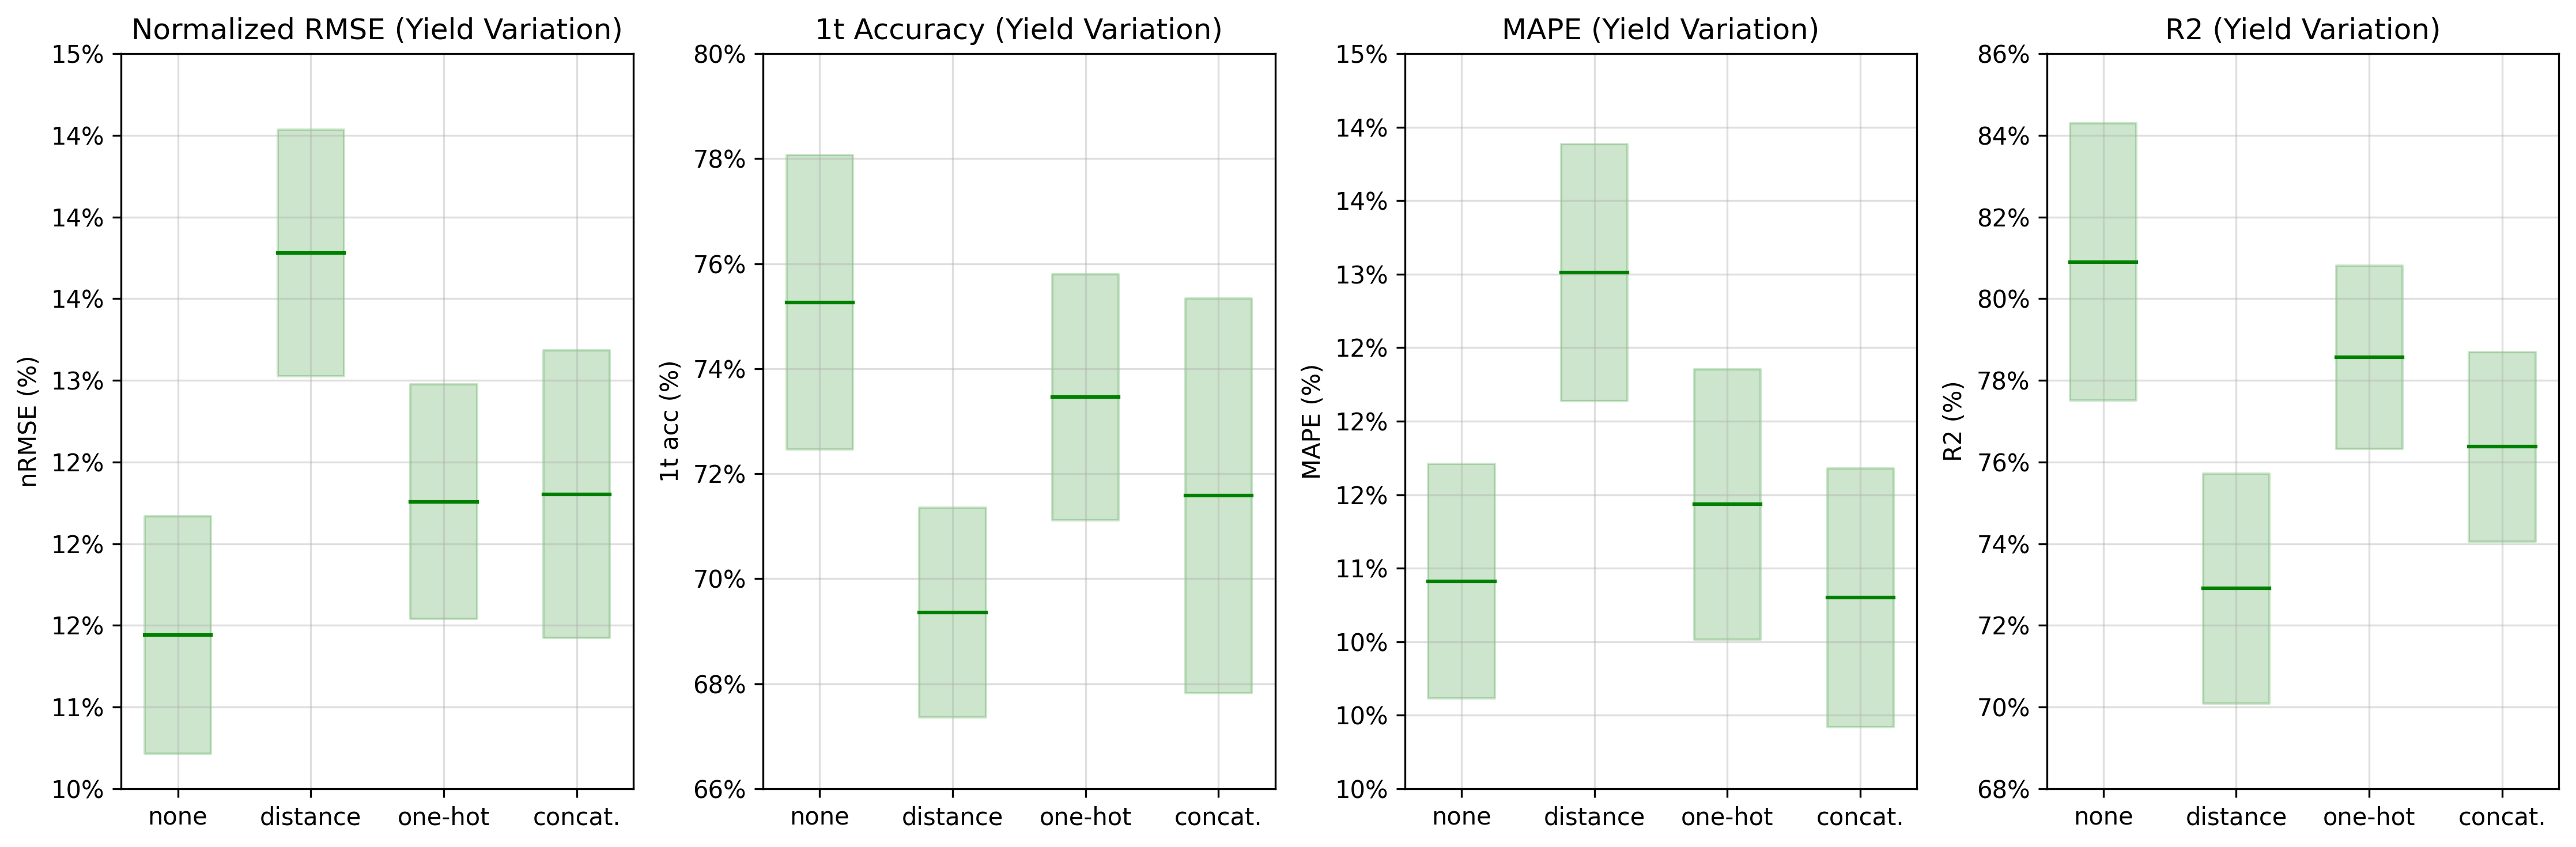

In [96]:
def load_data(base_url, K):
    
    unnorm = []
    norm = []
    for i in range(K):
        with open(base_url + str(i) + '.json', 'r') as f:
            scores_read = json.load(f)
            unnorm.append([s[0] for s in scores_read])
            norm.append([s[1] for s in scores_read])
    unnorm = np.array(unnorm)
    norm = np.array(norm)
    return unnorm, norm

switch = 3
if switch == 0:
    unnorm, norm = load_data('results_final/present_week/score', 7)
    weeks = [16, 18, 20, 22, 24, 26, 28]
    rotation = 'horizontal'
    xlabel = 'Week threshold' 
    color = 'orange'
    plot_type = "line"
elif switch == 1:
    weeks = [16, 18, 20, 22, 24, 26, 28, 'all']
    rotation = 'horizontal'
    xlabel = 'Week threshold'
    color = 'orange'
    plot_type = "line"
elif switch == 2:
    unnorm, norm = load_data('results_final/present_feature/score', 15)
    weeks = ["all", "-sen1", "-sen2", "-weather", "-soil", "sen1+sen2", "sen1+weather", "sen1+soil", "sen2+weather", "sen2+soil", "weather+soil", "sen1", "sen2", "weather", "soil"]
    rotation = 'vertical'
    xlabel = None
    plot_type = "bar"
elif switch == 3:
    unnorm, norm = load_data('results_final/present_scheme/score', 4)
    weeks = ["none", "distance", "one-hot", "concat."]
    rotation = 'horizontal'
    xlabel = None
    plot_type = "bar"


#y_mean = df['yield'].mean()
y_mean = 8.240367611225663
make_rel_rmse = True


def draw_conf(metric, x_label, kind, title, xs=None):
    if make_rel_rmse and kind == 'rmse': metric = metric/y_mean

    m = np.mean(metric, axis=1)
    se = 1.92*np.std(metric, axis=1)/np.sqrt(metric.shape[1])
    plt.grid(alpha=0.4)
    if plot_type == "line":
        plt.fill_between(range(len(metric)), m-se, m+se, alpha=0.2, color=color)
        plt.plot(range(len(metric)), m, color=color)
    else:
        if xs is None:
            for i in range(m.shape[0]):
                d = 1/4
                plt.fill_between([i-d, i+d], [m[i]-se[i]]*2, [m[i]+se[i]]*2, alpha=0.2, color=color)
                plt.plot([i-d, i+d], [m[i]]*2, color=color)
        else:
            for i in range(m.shape[0]):
                d = 1/4/2
                plt.fill_between([i+xs/6-d, i+xs/6+d], [m[i]-se[i]]*2, [m[i]+se[i]]*2, alpha=0.2, color=color)
                plt.plot([i+xs/6-d, i+xs/6+d], [m[i]]*2, color=color)
    
    
    plt.xticks(range(len(weeks)), [str(w) for w in weeks], rotation=rotation);
    if x_label is not None: plt.xlabel(xlabel)
    if (make_rel_rmse or kind != 'rmse'):
        ticks = plt.yticks()[0]
        plt.yticks(ticks, [str(round(t*100)) + "%" for t in ticks])
        
    if kind == 'acc':
        plt.ylabel("1t acc (%)")
    elif kind == 'rmse':
        plt.ylabel("RMSE (tons)")
        if make_rel_rmse:
            plt.ylabel("nRMSE (%)")
    elif kind == 'mape':
        plt.ylabel("MAPE (%)")
    elif kind == 'r2':
        plt.ylabel("R2 (%)")
    plt.title(title)



plt.figure(figsize=(15,5), dpi=300)
#plt.suptitle("Future Yield performance on prediction date")
sp_N, sp_M = 1, 4

if False:

    color='orange'
    plt.subplot(sp_N,sp_M,1)
    draw_conf(unnorm[:, :, 0], xlabel, 'rmse', 'Normalized RMSE (Absolute Yield)', xs=-1)
    plt.subplot(sp_N,sp_M,2)
    draw_conf(unnorm[:, :, 1], xlabel, '1t acc', '1t Accuracy (Absolute Yield)', xs=-1)
    plt.subplot(sp_N,sp_M,3)
    draw_conf(unnorm[:, :, 2], xlabel, 'mape', 'MAPE (Absolute Yield)', xs=-1)
    plt.subplot(sp_N,sp_M,4)
    draw_conf(unnorm[:, :, 3], xlabel, 'r2', 'R2 (Absolute Yield)', xs=-1)

color='green'
plt.subplot(sp_N,sp_M,1)
draw_conf(norm[:, :, 0], xlabel, 'rmse', 'Normalized RMSE (Yield Variation)')
plt.subplot(sp_N,sp_M,2)
draw_conf(norm[:, :, 1], xlabel, 'acc', '1t Accuracy (Yield Variation)')
plt.subplot(sp_N,sp_M,3)
draw_conf(norm[:, :, 2], xlabel, 'mape', 'MAPE (Yield Variation)')
plt.subplot(sp_N,sp_M,4)
draw_conf(norm[:, :, 3], xlabel, 'r2', 'R2 (Yield Variation)')

plt.tight_layout()

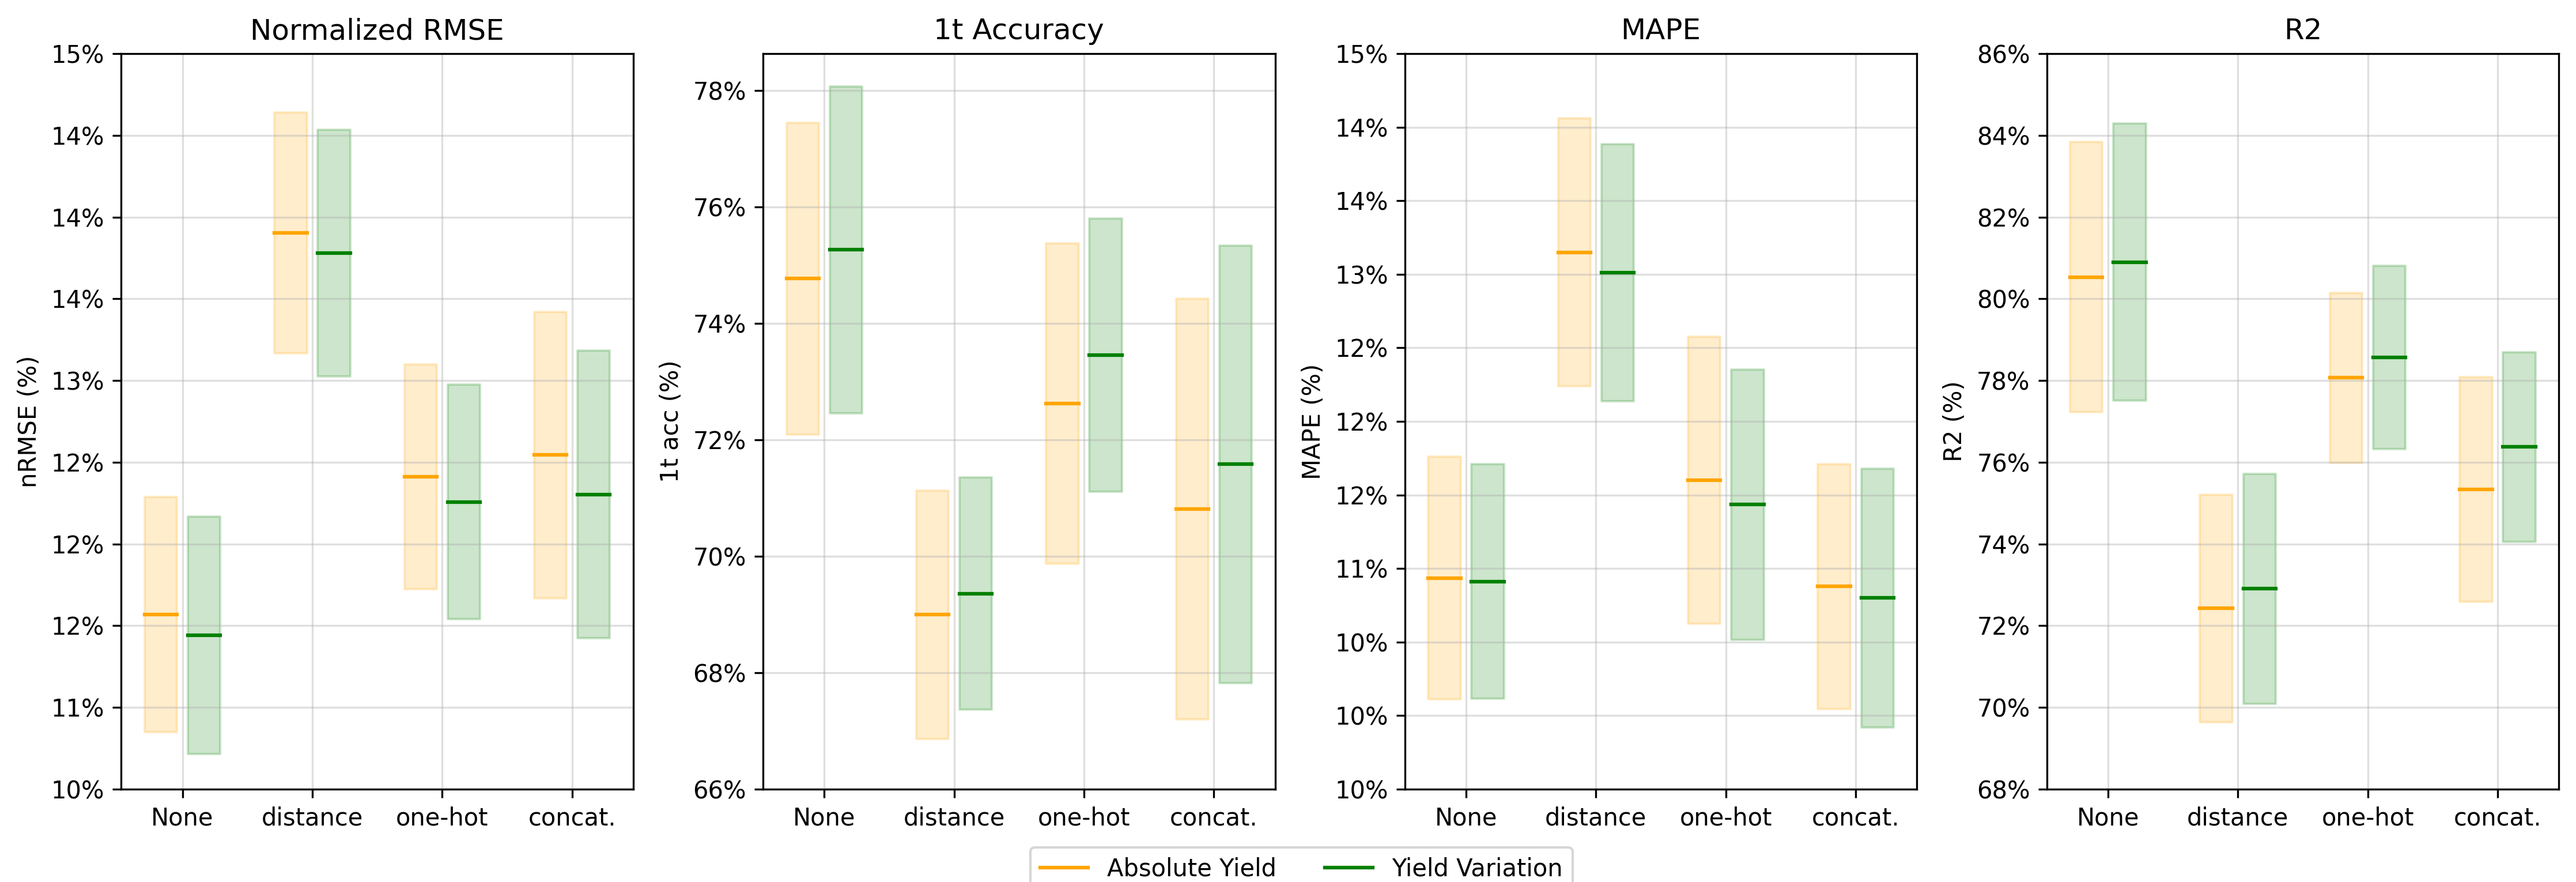

In [ ]:
def load_data(base_url, K):
    
    unnorm = []
    norm = []
    for i in range(K):
        with open(base_url + str(i) + '.json', 'r') as f:
            scores_read = json.load(f)
            unnorm.append([s[0] for s in scores_read])
            norm.append([s[1] for s in scores_read])
    unnorm = np.array(unnorm)
    norm = np.array(norm)
    return unnorm, norm

switch = 3
if switch == 0:
    unnorm, norm = load_data('results_final/present_week/score', 7)
    weeks = [16, 18, 20, 22, 24, 26, 28]
    rotation = 'horizontal'
    xlabel = 'Week threshold' 
    color = 'orange'
    plot_type = "line"
elif switch == 1:
    weeks = [16, 18, 20, 22, 24, 26, 28, 'all']
    rotation = 'horizontal'
    xlabel = 'Week threshold'
    color = 'orange'
    plot_type = "line"
elif switch == 2:
    unnorm, norm = load_data('results_final/present_feature/score', 15)
    weeks = ["all", "-sen1", "-sen2", "-weather", "-soil", "sen1+sen2", "sen1+weather", "sen1+soil", "sen2+weather", "sen2+soil", "weather+soil", "sen1", "sen2", "weather", "soil"]
    rotation = 'vertical'
    xlabel = None
    plot_type = "bar"
elif switch == 3:
    unnorm, norm = load_data('results_final/present_scheme/score', 4)
    weeks = ["None", "distance", "one-hot", "concat."]
    rotation = 'horizontal'
    xlabel = None
    plot_type = "bar"


#y_mean = df['yield'].mean()
y_mean = 8.240367611225663
make_rel_rmse = True


def draw_conf(metric, x_label, kind, title, xs=None):
    if make_rel_rmse and kind == 'rmse': metric = metric/y_mean

    m = np.mean(metric, axis=1)
    se = 1.92*np.std(metric, axis=1)/np.sqrt(metric.shape[1])
    plt.grid(alpha=0.4)
    if plot_type == "line":
        plt.fill_between(range(len(metric)), m-se, m+se, alpha=0.2, color=color)
        plt.plot(range(len(metric)), m, color=color)
    else:
        if xs is None:
            for i in range(m.shape[0]):
                d = 1/4
                plt.plot([i-d, i+d], [m[i]]*2, color=color, label="TEST" if i == 0 else None)
                plt.fill_between([i-d, i+d], [m[i]-se[i]]*2, [m[i]+se[i]]*2, alpha=0.2, color=color)
        else:
            d = 1/4/2
            for i in range(m.shape[0]):
                plt.plot([i+xs/6-d, i+xs/6+d], [m[i]]*2, color=color, label="TEST" if i == 0 else None)
            for i in range(m.shape[0]):
                plt.fill_between([i+xs/6-d, i+xs/6+d], [m[i]-se[i]]*2, [m[i]+se[i]]*2, alpha=0.2, color=color)
    
    
    plt.xticks(range(len(weeks)), [str(w) for w in weeks], rotation=rotation);
    if x_label is not None: plt.xlabel(xlabel)
    if (make_rel_rmse or kind != 'rmse'):
        ticks = plt.yticks()[0]
        plt.yticks(ticks, [str(round(t*100)) + "%" for t in ticks])
        
    if kind == 'acc':
        plt.ylabel("1t acc (%)")
    elif kind == 'rmse':
        plt.ylabel("RMSE (tons)")
        if make_rel_rmse:
            plt.ylabel("nRMSE (%)")
    elif kind == 'mape':
        plt.ylabel("MAPE (%)")
    elif kind == 'r2':
        plt.ylabel("R2 (%)")
    plt.title(title)



fig = plt.figure(figsize=(15,5), dpi=300)
#plt.suptitle("Future Yield performance on prediction date")
sp_N, sp_M = 1, 4

if True:

    color='orange'
    plt.subplot(sp_N,sp_M,1)
    draw_conf(unnorm[:, :, 0], xlabel, 'rmse', 'Normalized RMSE (Absolute Yield)', xs=-1)
    plt.subplot(sp_N,sp_M,2)
    draw_conf(unnorm[:, :, 1], xlabel, 'acc', '1t Accuracy (Absolute Yield)', xs=-1)
    plt.subplot(sp_N,sp_M,3)
    draw_conf(unnorm[:, :, 2], xlabel, 'mape', 'MAPE (Absolute Yield)', xs=-1)
    plt.subplot(sp_N,sp_M,4)
    draw_conf(unnorm[:, :, 3], xlabel, 'r2', 'R2 (Absolute Yield)', xs=-1)

color='green'
ax = plt.subplot(sp_N,sp_M,1)
draw_conf(norm[:, :, 0], xlabel, 'rmse', 'Normalized RMSE', xs=1)
plt.subplot(sp_N,sp_M,2)
draw_conf(norm[:, :, 1], xlabel, '1t acc', '1t Accuracy', xs=1)
plt.subplot(sp_N,sp_M,3)
draw_conf(norm[:, :, 2], xlabel, 'mape', 'MAPE', xs=1)
plt.subplot(sp_N,sp_M,4)
draw_conf(norm[:, :, 3], xlabel, 'r2', 'R2', xs=1)


#fig.legend([line1, line2], ["Absolute Yield", "Yield Variation"], loc = (0.5, 0), ncol=5)
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels[:1])]

# Finally, the legend (that maybe you'll customize differently)
fig.legend(lines, ["Absolute Yield", "Yield Variation"], loc=(.4,-0.01), ncol=2)

plt.tight_layout()

In [43]:
[ax.get_legend_handles_labels() for ax in fig.axes]

[([<matplotlib.lines.Line2D at 0x7aff8d55f2f0>,
  ['TEST', 'TEST']),
 ([<matplotlib.lines.Line2D at 0x7aff86109700>,
  ['TEST', 'TEST']),
 ([<matplotlib.lines.Line2D at 0x7aff8c0e09e0>,
  ['TEST', 'TEST']),
 ([<matplotlib.lines.Line2D at 0x7affa17d9b80>,
  ['TEST', 'TEST'])]

In [ ]:
futurum_metrics = np.array([
[1.604, 0.257, 0.492, 0.811],
[1.572, 0.202, 0.431, 0.809],
[1.684, 0.215, 0.429, 0.778],
[1.554, 0.285, 0.506, 0.815],
[1.497, 0.312, 0.576, 0.838],
[1.39, 0.274, 0.523, 0.86],
[1.331, 0.339, 0.586, 0.862],
[1.948, 0.211, 0.374, 0.679],
[2.32, 0.161, 0.318, 0.626],
[1.466, 0.267, 0.504, 0.829]
])


m, se = np.mean(futurum_metrics[:, 0]), 1.92*np.std(futurum_metrics[:, 0])/np.sqrt(9)
print('with time (rmse):', np.round([m-se, m, m+se], 3))

print(" ")

m, se = np.mean(futurum_metrics[:, 2]), 1.92*np.std(futurum_metrics[:, 2])/np.sqrt(9)
print('with time (1t acc):', np.round([m-se, m, m+se], 3))


with time (rmse): [1.458 1.637 1.815]
 
with time (1t acc): [0.422 0.474 0.526]


Text(0, 0.5, 'Relative RMSE (%)')

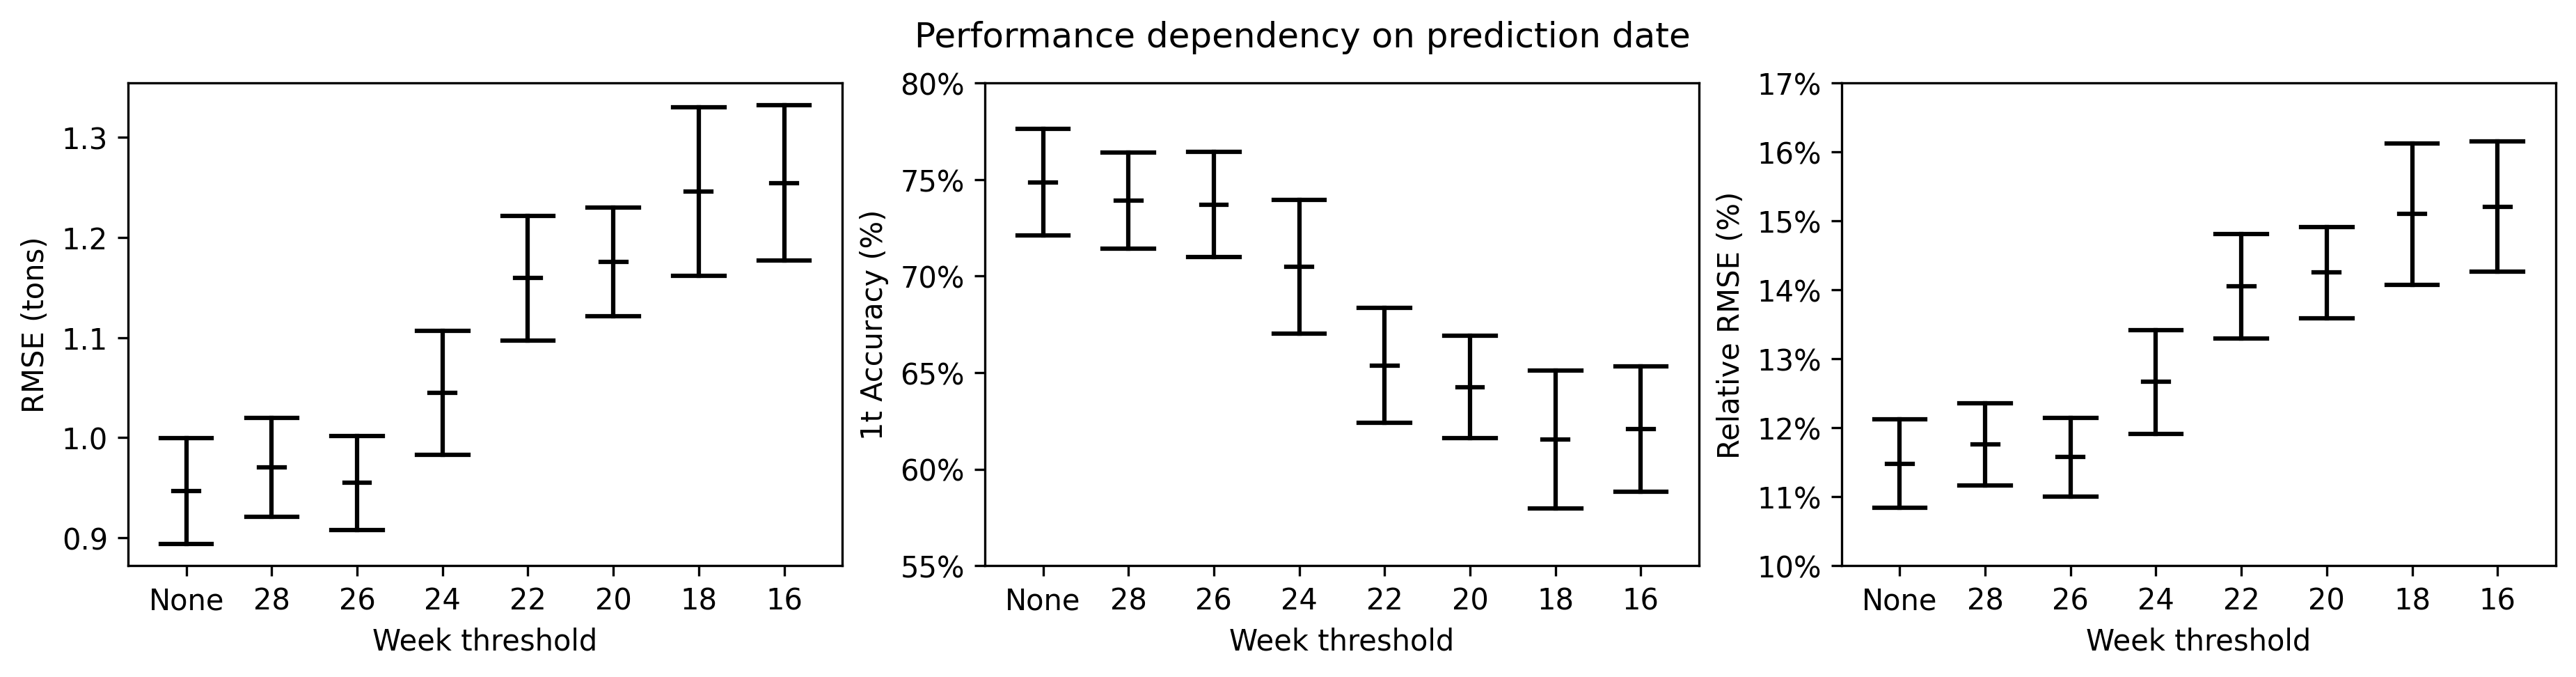

In [60]:


rmse = [
(0.8941256786407036, 0.9470347789863057, 0.9999438793319079),
(0.9212173571989176, 0.9705015907148674, 1.019785824230817),
(0.9079124813732142, 0.9549696436419165, 1.0020268059106188),
(0.9828069209773307, 1.0449596960702023, 1.107112471163074),
(1.0970856219777425, 1.1594880759138917, 1.2218905298500409),
(1.1214667915539858, 1.1758567686480683, 1.2302467457421509),
(1.1614942090624532, 1.2457076146116792, 1.3299210201609053),
(1.1767991643319011, 1.2546017219457077, 1.3324042795595143),
]
acc_1t=[
(0.7211073928568519, 0.7486062895130906, 0.7761051861693293),
(0.7143238960013922, 0.739097620239397, 0.7638713444774017),
(0.7097178233792261, 0.7370112361006422, 0.7643046488220584),
(0.6702316087001832, 0.7047664177171634, 0.7393012267341437),
(0.6238483328071176, 0.6536231286711802, 0.6833979245352428),
(0.6159039345380211, 0.6425128967167841, 0.6691218588955472),
(0.5797594832905939, 0.6153413438072803, 0.6509232043239668),
(0.5883868927192434, 0.620731158382525, 0.6530754240458067)]
rel_rmse = [
(0.10836611069742531, 0.11477857995305518, 0.12119104920868505),
(0.11164956391630805, 0.11762270710233805, 0.12359585028836804),
(0.11003704155956776, 0.11574026849660113, 0.1214434954336345),
(0.1191140866849239, 0.12664686945446207, 0.13417965222400025),
(0.13296441965130876, 0.14052746296007063, 0.1480905062688325),
(0.1359193650066961, 0.1425113133417089, 0.14910326167672172),
(0.14077060198632171, 0.15097708575695698, 0.16118356952759225),
(0.1426255296732991, 0.15205503245163118, 0.16148453522996326)]

weeks = [None, 28, 26, 24, 22, 20, 18, 16]
plt.figure(figsize=(15,3), dpi=300)
plt.suptitle("Performance dependency on prediction date")

#print("rmse")
plt.subplot(1,3,1)
for i, conf in enumerate(rmse):
    plt.plot([i]*3, conf, 'k')
    plt.plot(i+0.3*np.array([-1, 1]), [conf[0]]*2, 'k')
    plt.plot(i+0.15*np.array([-1, 1]), [conf[1]]*2, 'k')
    plt.plot(i+0.3*np.array([-1, 1]), [conf[2]]*2, 'k')
plt.xticks(range(len(weeks)), [str(w) for w in weeks]);
plt.xlabel("Week threshold")
plt.ylabel("RMSE (tons)")


#print("1t acc")
plt.subplot(1,3,2)
for i, conf in enumerate(acc_1t):
    plt.plot([i]*3, conf, 'k')
    plt.plot(i+0.3*np.array([-1, 1]), [conf[0]]*2, 'k')
    plt.plot(i+0.15*np.array([-1, 1]), [conf[1]]*2, 'k')
    plt.plot(i+0.3*np.array([-1, 1]), [conf[2]]*2, 'k')
plt.xticks(range(len(weeks)), [str(w) for w in weeks]);
ticks = plt.yticks()[0]
plt.yticks(ticks, [str(round(t*100)) + "%" for t in ticks])
plt.xlabel("Week threshold")
plt.ylabel("1t Accuracy (%)")
    
    

#print("rel rmse")
plt.subplot(1,3,3)
for i, conf in enumerate(rel_rmse):
    plt.plot([i]*3, conf, 'k')
    plt.plot(i+0.3*np.array([-1, 1]), [conf[0]]*2, 'k')
    plt.plot(i+0.15*np.array([-1, 1]), [conf[1]]*2, 'k')
    plt.plot(i+0.3*np.array([-1, 1]), [conf[2]]*2, 'k')
plt.xticks(range(len(weeks)), [str(w) for w in weeks]);
ticks = plt.yticks()[0]
plt.yticks(ticks, [str(round(t*100)) + "%" for t in ticks])
plt.xlabel("Week threshold")
plt.ylabel("Relative RMSE (%)")


In [92]:
# performance on unseen year, with or without time connection
wt = np.array([
    [1.155, 0.268, 0.491, 0.813, 0.14],
    [1.429, 0.169, 0.356, 0.678, 0.173],
    [1.092, 0.215, 0.426, 0.761, 0.132],
    [1.668, 0.32, 0.579, 0.848, 0.202],
    [1.424, 0.328, 0.621, 0.894, 0.173],
    [1.009, 0.299, 0.564, 0.874, 0.122],
    [1.374, 0.074, 0.185, 0.589, 0.166],
    [1.544, 0.301, 0.555, 0.858, 0.187],
    [0.976, 0.219, 0.432, 0.762, 0.118],
    [1.587, 0.149, 0.304, 0.607, 0.192]
])


wot = np.array([
    [0.99, 0.193, 0.372, 0.813, 0.12],
    [1.242, 0.166, 0.319, 0.64, 0.151],
    [0.925, 0.175, 0.395, 0.82, 0.112],
    [1.007, 0.178, 0.371, 0.815, 0.122],
    [0.97, 0.271, 0.517, 0.897, 0.118],
    [1.159, 0.378, 0.613, 0.821, 0.141],
    [1.169, 0.136, 0.322, 0.689, 0.142],
    [0.941, 0.252, 0.478, 0.834, 0.114],
    [1.733, 0.344, 0.584, 0.86, 0.21],
    [1.027, 0.272, 0.525, 0.815, 0.124]
])


wot_small = np.array([
    [2.547, 0.241, 0.468, 0.734, 0.309],
    [1.874, 0.158, 0.319, 0.664, 0.227],
    [1.831, 0.229, 0.457, 0.736, 0.222],
    [1.597, 0.247, 0.434, 0.776, 0.194],
    [1.46, 0.319, 0.599, 0.866, 0.177],
    [1.712, 0.249, 0.448, 0.767, 0.207],
    [1.589, 0.354, 0.599, 0.82, 0.193],
    [1.68, 0.262, 0.526, 0.806, 0.204],
    [1.218, 0.338, 0.609, 0.896, 0.148],
    [2.451, 0.159, 0.292, 0.514, 0.297],
])

m, se = np.mean(wt[:, 0]), 1.92*np.std(wt[:, 0])/np.sqrt(9)
print('with time (rmse):', np.round([m-se, m, m+se], 3))

m, se = np.mean(wot[:, 0]), 1.92*np.std(wot[:, 0])/np.sqrt(9)
print('without time (rmse):', np.round([m-se, m, m+se], 3))

m, se = np.mean(wot_small[:, 0]), 1.92*np.std(wot_small[:, 0])/np.sqrt(9)
print('without time (rmse):', np.round([m-se, m, m+se], 3))

print(" ")

m, se = np.mean(wt[:, 2]), 1.92*np.std(wt[:, 2])/np.sqrt(9)
print('with time (1t acc):', np.round([m-se, m, m+se], 3))

m, se = np.mean(wot[:, 2]), 1.92*np.std(wot[:, 2])/np.sqrt(9)
print('without time (1t acc):', np.round([m-se, m, m+se], 3))

m, se = np.mean(wot_small[:, 2]), 1.92*np.std(wot_small[:, 2])/np.sqrt(9)
print('without time (1t acc):', np.round([m-se, m, m+se], 3))

with time (rmse): [1.174 1.326 1.478]
without time (rmse): [0.97  1.116 1.263]
without time (rmse): [1.544 1.796 2.048]
 
with time (1t acc): [0.367 0.451 0.535]
without time (1t acc): [0.384 0.45  0.515]
without time (1t acc): [0.407 0.475 0.543]


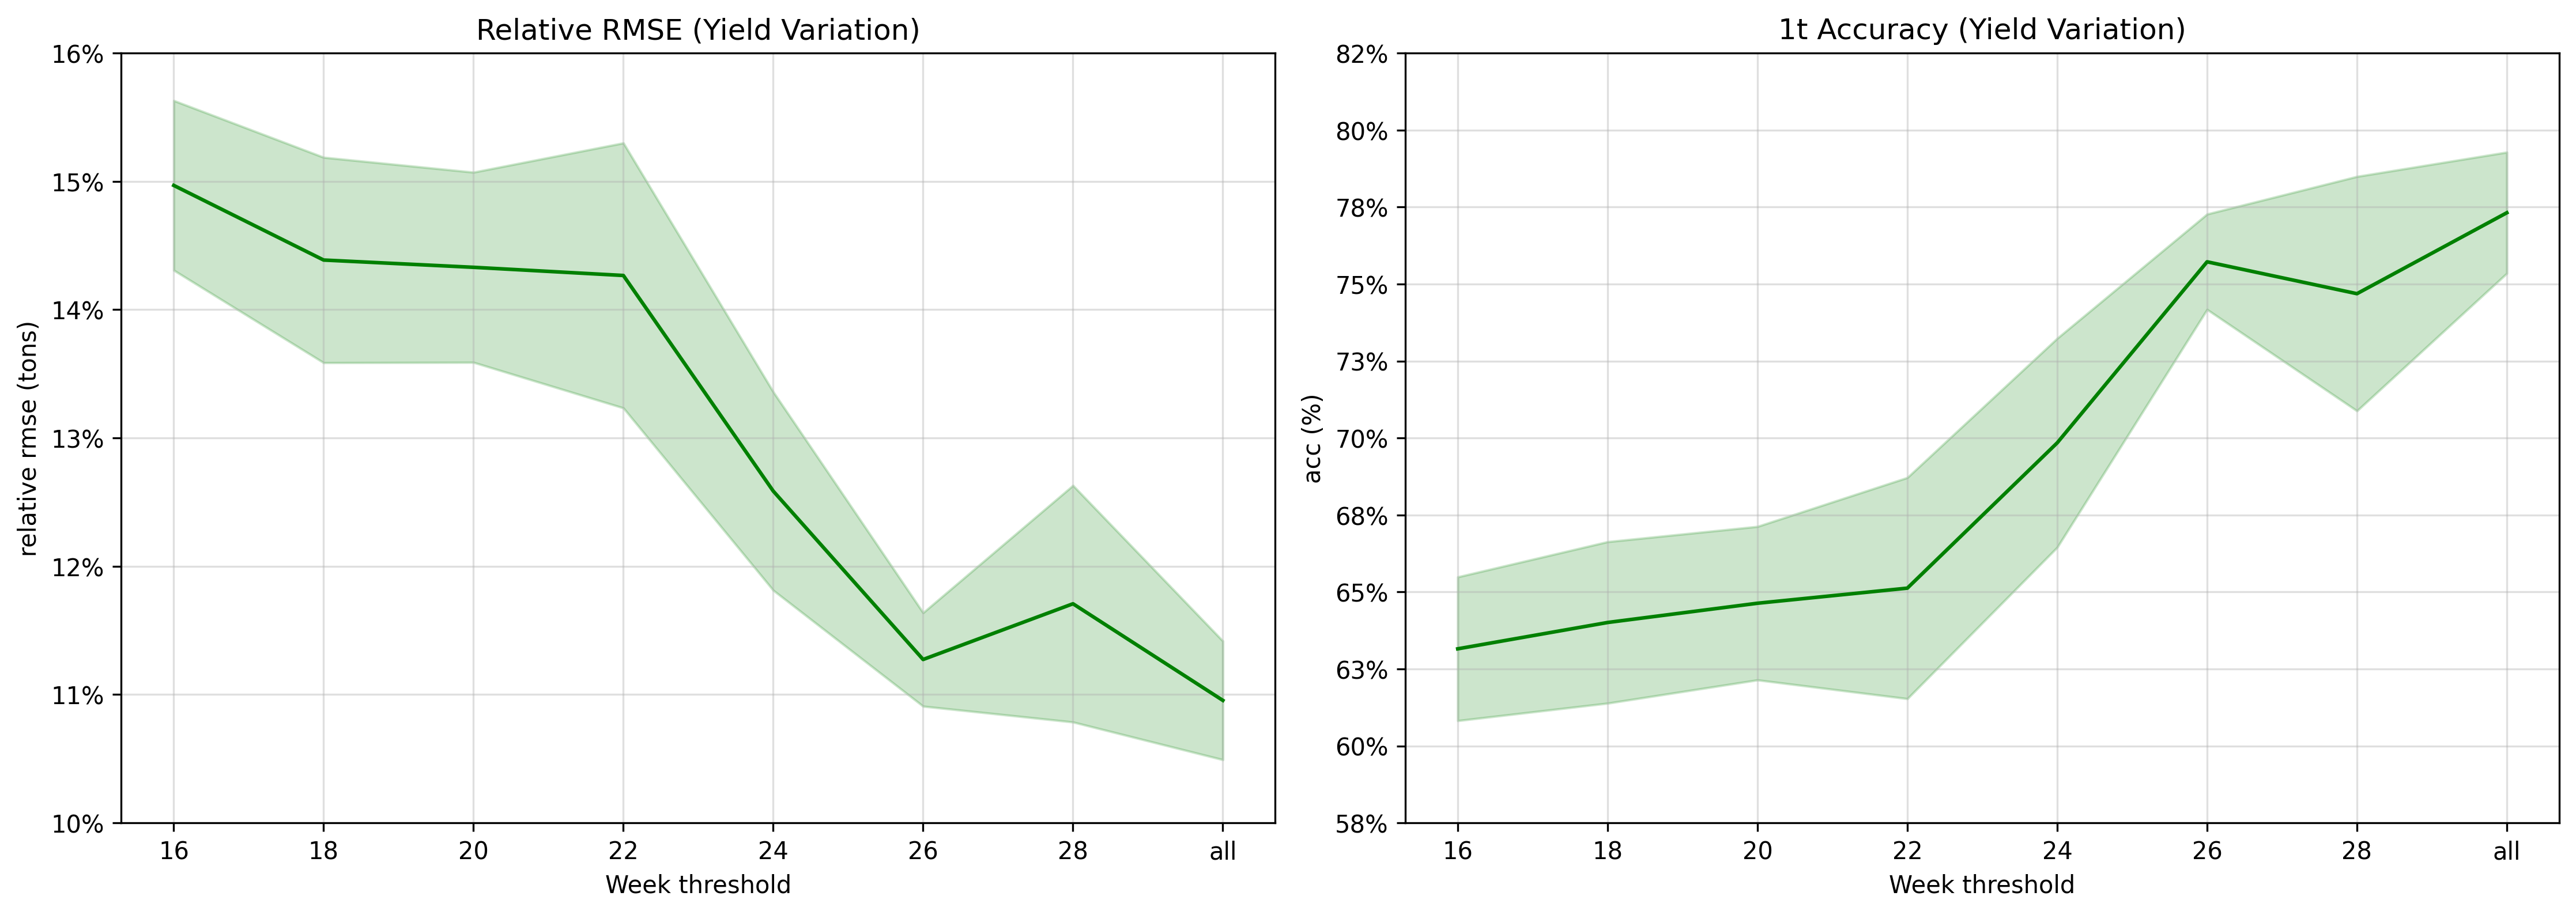

In [49]:
# futurum with extra weeks
import numpy as np
import matplotlib.pyplot as plt


color = 'k'

switch = 1
if switch == 0:
    filename = 'results/futurum_plus_weeks.txt'
    weeks = [0, 16, 18, 20, 22, 24, 26, 28]
    rotation = 'horizontal'
    xlabel = 'Week threshold' 
    color = 'orange'
elif switch == 1:
    filename = 'results/present_with_weeks.txt'
    weeks = [16, 18, 20, 22, 24, 26, 28, 'all']
    rotation = 'horizontal'
    xlabel = 'Week threshold'
    color = 'orange'
elif switch == 2:
    filename = 'results/present_ablation.txt'
    weeks = ["all", "-sen1", "-sen2", "-weather", "-soil", "sen1+sen2", "sen1+weather", "sen1+soil", "sen2+weather", "sen2+soil", "weather+soil", "sen1", "sen2", "weather", "soil"]
    rotation = 'vertical'
    xlabel = None


#y_mean = df['yield'].mean()
y_mean = 8.240367611225663
make_rel_rmse = True


with open(filename, 'r') as f:
    text = f.read()
    f.close()


data = np.array([[float(i) for i in line.split("]]")[0].replace("], [", ", ").split(", ")] for line in text.split("\n[[")[1:]])

K = 10
metric_list = {
    'normalized': {
        'rmse': [],
        'acc_1t': []
    },
    'unnormalized': {
        'rmse': [],
        'acc_1t': []
    }
}
for i in range(int(data.shape[0]/K)):
    metrics = data[K*i:K*(i+1), :]

    metric = metrics[:, 0]
    m = np.mean(metric)
    se = 1.92*np.std(metric)/np.sqrt(metric.shape[0]-1)
    if make_rel_rmse:
        m = m/y_mean
        se /= y_mean
    metric_list['unnormalized']['rmse'].append((m-se, m, m+se))

    metric = metrics[:, 1]
    m = np.mean(metric)
    se = 1.92*np.std(metric)/np.sqrt(metric.shape[0]-1)
    metric_list['unnormalized']['acc_1t'].append((m-se, m, m+se))

    metric = metrics[:, 2]
    m = np.mean(metric)
    se = 1.92*np.std(metric)/np.sqrt(metric.shape[0]-1)
    if make_rel_rmse:
        m = m/y_mean
        se /= y_mean
    metric_list['normalized']['rmse'].append((m-se, m, m+se))

    metric = metrics[:, 3]
    m = np.mean(metric)
    se = 1.92*np.std(metric)/np.sqrt(metric.shape[0]-1)
    metric_list['normalized']['acc_1t'].append((m-se, m, m+se))
    

def draw_conf_1(metric, x_label, kind, title):
    for i, conf in enumerate(metric):
        plt.plot([i]*3, conf, 'k')
        plt.plot(i+0.3*np.array([-1, 1]), [conf[0]]*2, color)
        plt.plot(i+0.15*np.array([-1, 1]), [conf[1]]*2, color)
        plt.plot(i+0.3*np.array([-1, 1]), [conf[2]]*2, color)
    plt.xticks(range(len(weeks)), [str(w) for w in weeks], rotation=rotation);
    if x_label is not None: plt.xlabel(xlabel)
    if kind == 'acc':
        ticks = plt.yticks()[0]
        plt.yticks(ticks, [str(round(t*100)) + "%" for t in ticks])
        plt.ylabel("acc (%)")
    else:
        plt.ylabel("rmse (tons)")
        if make_rel_rmse:
            plt.ylabel("relative rmse (tons)")
    plt.title(title)
    
    
def draw_conf_2(metric, x_label, kind, title):
    plt.grid(alpha=0.4)
    plt.fill_between(range(len(metric)), [conf[0] for conf in metric], [conf[2] for conf in metric], alpha=0.2, color=color)
    plt.plot(range(len(metric)), [conf[1] for conf in metric], color=color)
    
    
    plt.xticks(range(len(weeks)), [str(w) for w in weeks], rotation=rotation);
    if x_label is not None: plt.xlabel(xlabel)
    if kind == 'acc' or make_rel_rmse:
        ticks = plt.yticks()[0]
        plt.yticks(ticks, [str(round(t*100)) + "%" for t in ticks])
        
    if kind == 'acc':
        plt.ylabel("acc (%)")
    else:
        plt.ylabel("RMSE (tons)")
        if make_rel_rmse:
            plt.ylabel("relative rmse (tons)")
    plt.title(title)

draw_conf = draw_conf_2

plt.figure(figsize=(15,10), dpi=300)
#plt.suptitle("Future Yield performance on prediction date")

#print("rmse")
plt.subplot(2,2,1)
#draw_conf(metric_list['unnormalized']['rmse'], xlabel, 'rmse', 'RMSE (Absolute Yield)')

plt.subplot(2,2,2)
#draw_conf(metric_list['unnormalized']['acc_1t'], xlabel, 'acc', '1t Accuracy (Absolute Yield)')

color='green'
plt.subplot(2,2,1)
draw_conf(metric_list['normalized']['rmse'], xlabel, 'rmse', 'Relative RMSE (Yield Variation)')

plt.subplot(2,2,2)
draw_conf(metric_list['normalized']['acc_1t'], xlabel, 'acc', '1t Accuracy (Yield Variation)')

plt.tight_layout()


Text(0.5, 1.0, '1t Accuracy (Yield Variation)')

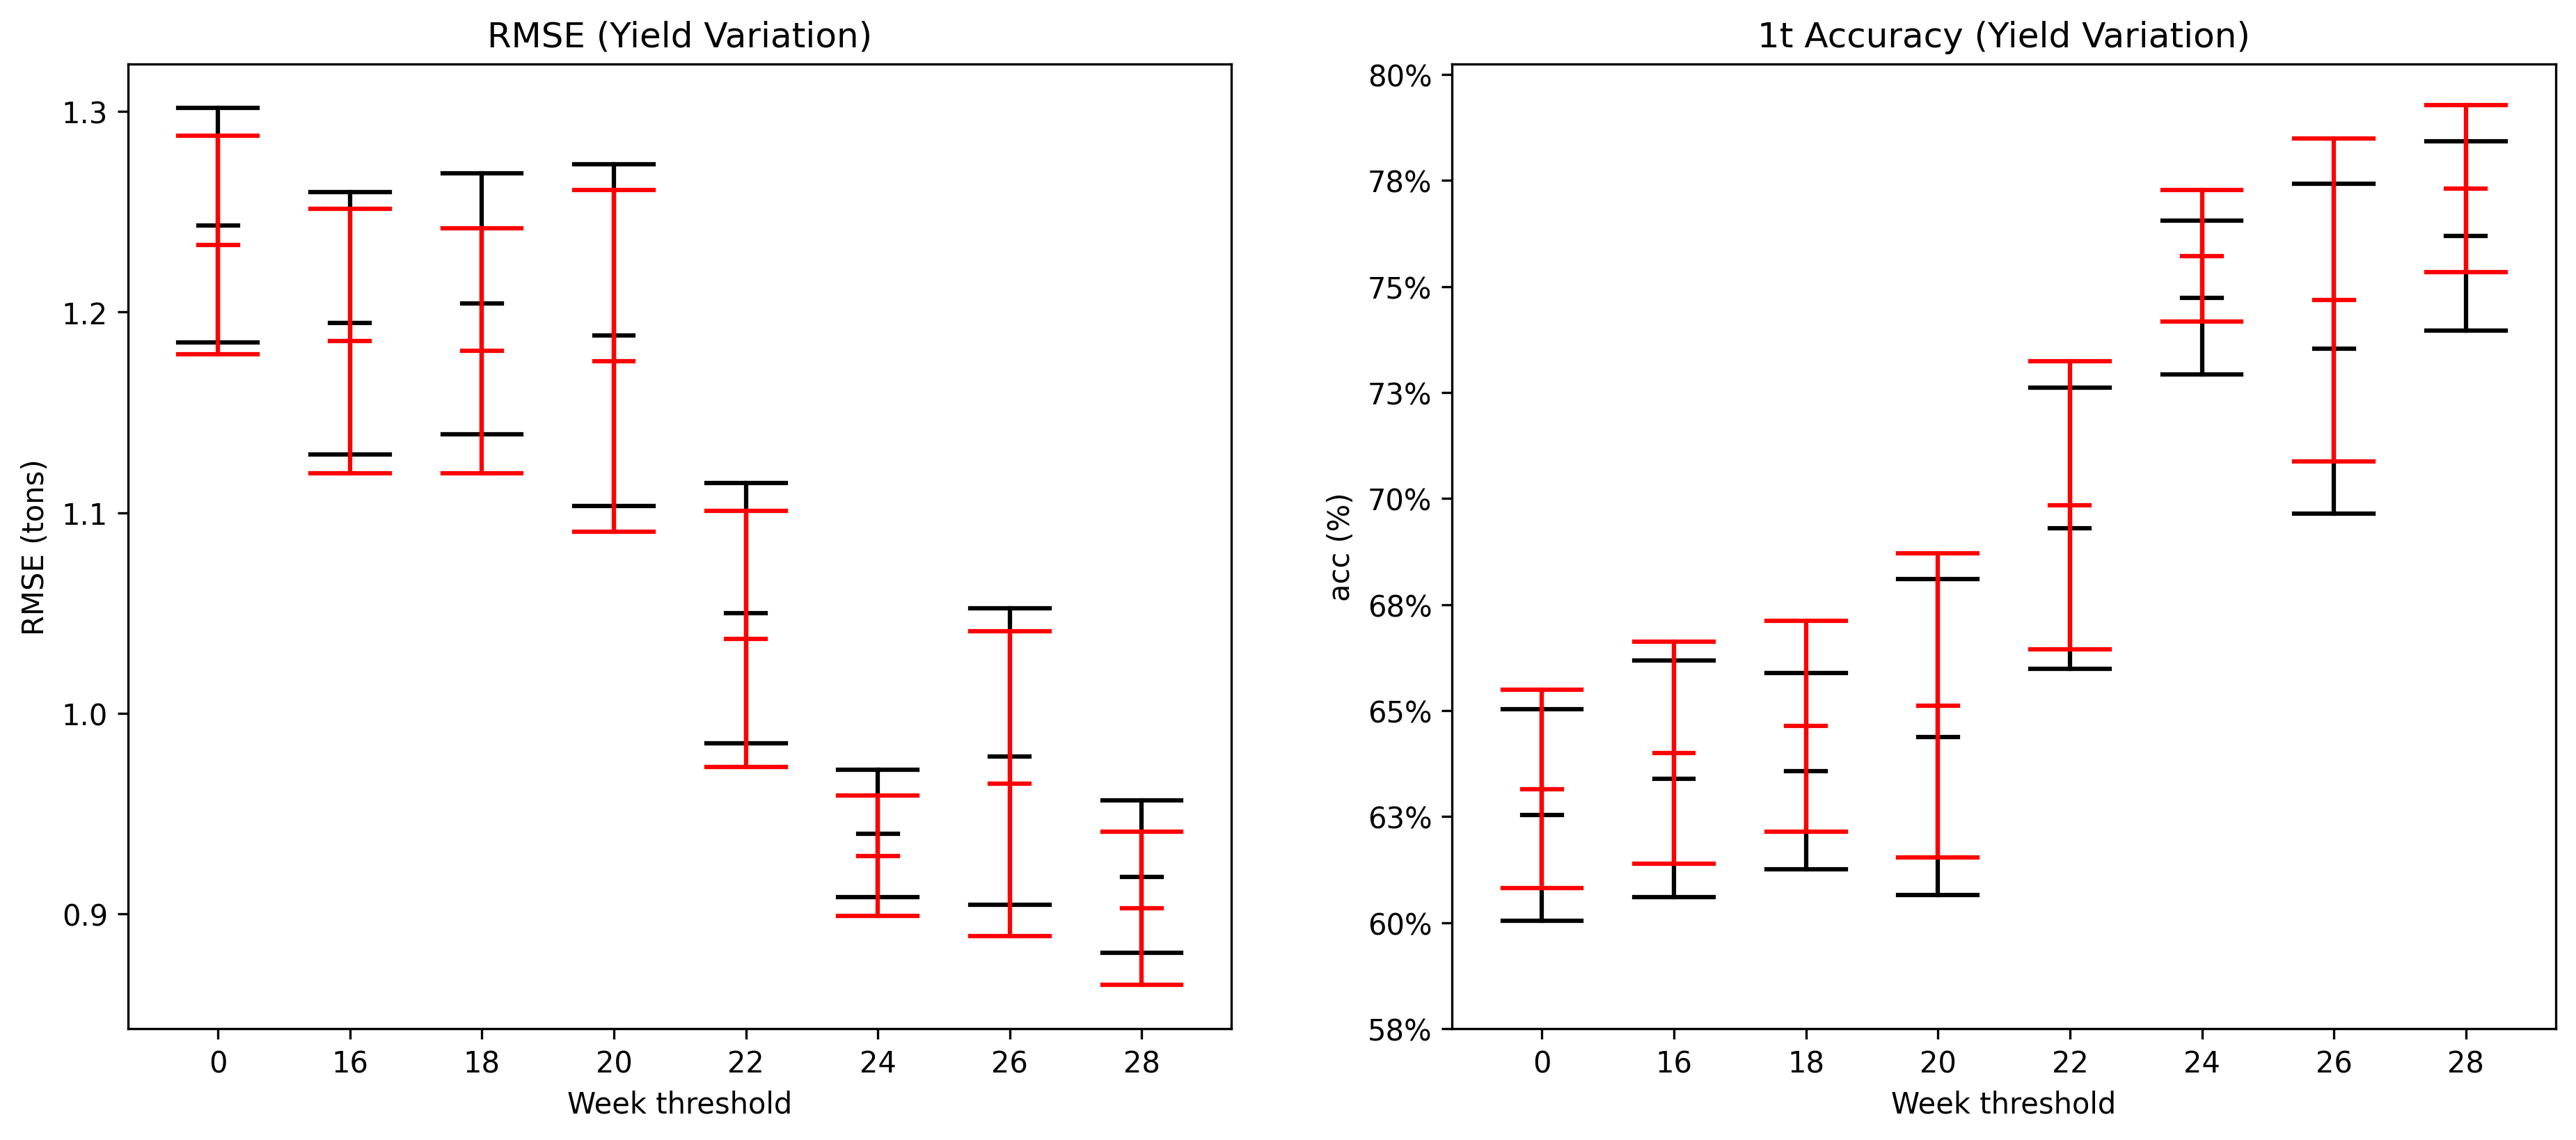

In [22]:
# futurum with extra weeks
import numpy as np
import matplotlib.pyplot as plt


filename = 'results/futurum_plus_weeks.txt'
filename = 'results/present_with_weeks.txt'

with open(filename, 'r') as f:
    text = f.read()
    f.close()


data = np.array([[float(i) for i in line.split("]]")[0].replace("], [", ", ").split(", ")] for line in text.split("\n[[")[1:]])

K = 10
metric_list = {
    'normalized': {
        'rmse': [],
        'acc_1t': []
    },
    'unnormalized': {
        'rmse': [],
        'acc_1t': []
    }
}
for i in range(int(data.shape[0]/K)):
    metrics = data[K*i:K*(i+1), :]

    metric = metrics[:, 0]
    m = np.mean(metric)
    se = 1.92*np.std(metric)/np.sqrt(metric.shape[0]-1)
    metric_list['unnormalized']['rmse'].append((m-se, m, m+se))

    metric = metrics[:, 1]
    m = np.mean(metric)
    se = 1.92*np.std(metric)/np.sqrt(metric.shape[0]-1)
    metric_list['unnormalized']['acc_1t'].append((m-se, m, m+se))

    metric = metrics[:, 2]
    m = np.mean(metric)
    se = 1.92*np.std(metric)/np.sqrt(metric.shape[0]-1)
    metric_list['normalized']['rmse'].append((m-se, m, m+se))

    metric = metrics[:, 3]
    m = np.mean(metric)
    se = 1.92*np.std(metric)/np.sqrt(metric.shape[0]-1)
    metric_list['normalized']['acc_1t'].append((m-se, m, m+se))
    

weeks = [0, 16, 18, 20, 22, 24, 26, 28]


plt.figure(figsize=(15,6), dpi=300)
#plt.suptitle("Future Yield performance on prediction date")

#print("rmse")
color = 'k'
plt.subplot(1,2,1)
for i, conf in enumerate(metric_list['unnormalized']['rmse']):
    plt.plot([i]*3, conf, 'k')
    plt.plot(i+0.3*np.array([-1, 1]), [conf[0]]*2, color)
    plt.plot(i+0.15*np.array([-1, 1]), [conf[1]]*2, color)
    plt.plot(i+0.3*np.array([-1, 1]), [conf[2]]*2, color)
plt.xticks(range(len(weeks)), [str(w) for w in weeks]);
plt.xlabel("Week threshold")
plt.ylabel("RMSE (tons)")
plt.title('RMSE (Absolute Yield)')


#print("1t acc")
plt.subplot(1,2,2)
for i, conf in enumerate(metric_list['unnormalized']['acc_1t']):
    plt.plot([i]*3, conf, 'k')
    plt.plot(i+0.3*np.array([-1, 1]), [conf[0]]*2, color)
    plt.plot(i+0.15*np.array([-1, 1]), [conf[1]]*2, color)
    plt.plot(i+0.3*np.array([-1, 1]), [conf[2]]*2, color)
plt.xticks(range(len(weeks)), [str(w) for w in weeks]);
ticks = plt.yticks()[0]
plt.yticks(ticks, [str(round(t*100)) + "%" for t in ticks])
plt.xlabel("Week threshold")
plt.ylabel("acc (%)")
plt.title('1t Accuracy (Absolute Yield)')


color = 'r'
plt.subplot(1,2,1)
for i, conf in enumerate(metric_list['normalized']['rmse']):
    plt.plot([i]*3, conf, color)
    plt.plot(i+0.3*np.array([-1, 1]), [conf[0]]*2, color)
    plt.plot(i+0.15*np.array([-1, 1]), [conf[1]]*2, color)
    plt.plot(i+0.3*np.array([-1, 1]), [conf[2]]*2, color)
plt.xticks(range(len(weeks)), [str(w) for w in weeks]);
plt.xlabel("Week threshold")
plt.ylabel("RMSE (tons)")
plt.title('RMSE (Yield Variation)')


#print("1t acc")
plt.subplot(1,2,2)
for i, conf in enumerate(metric_list['normalized']['acc_1t']):
    plt.plot([i]*3, conf, color)
    plt.plot(i+0.3*np.array([-1, 1]), [conf[0]]*2, color)
    plt.plot(i+0.15*np.array([-1, 1]), [conf[1]]*2, color)
    plt.plot(i+0.3*np.array([-1, 1]), [conf[2]]*2, color)
plt.xticks(range(len(weeks)), [str(w) for w in weeks]);
ticks = plt.yticks()[0]
plt.yticks(ticks, [str(round(t*100)) + "%" for t in ticks])
plt.xlabel("Week threshold")
plt.ylabel("acc (%)")
plt.title('1t Accuracy (Yield Variation)')
